# CORE

## Importing Libraries

In [ ]:
!pip install pyspark
!pip install pyecharts
!pip install snapshot-selenium
!pip install matplotlib

In [ ]:
!pip install streamlit

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from pyspark.sql  import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf() \
          .setMaster('local[*]') \
          .setAppName('SB Analytics') \
          .set('spark.driver.memory', '20g') \
          .set('spark.driver.maxResultSizeSets', '8g')
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [ ]:
from pyspark.sql.functions import expr, col, count, sum as sum_, max as max_, min as min_, avg as avg_, round as round_,\
                                  lower, when, udf, mean as mean_, stddev as stddev_, array, struct, product, \
                                  first, last, lit, split, isnan, months_between, row_number, coalesce, size, exp, \
                                  explode, array_repeat, date_format, date_trunc, to_date, to_timestamp, broadcast
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window
from pyspark.sql import functions as F

import math
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import avg
from functools import reduce
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.types import IntegerType, FloatType, DoubleType

from pyecharts.globals import CurrentConfig, NotebookType
from pyecharts.render import make_snapshot
from pyecharts.options import *
from pyecharts.charts import Bar, Grid
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.feature import Imputer

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.feature import VectorAssembler, StandardScaler

from IPython.display import display
import streamlit as st

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.calibration import calibration_curve

## Upload Dataset

In [ ]:
dfIC = spark.read.load('/content/drive/MyDrive/db/ic')
dfPatients = spark.read.load('/content/drive/MyDrive/db/patients')
dfObservations = spark.read.load('/content/drive/MyDrive/db/observations')
dfConditions = spark.read.load('/content/drive/MyDrive/db/conditions')
#dfMedications = spark.read.load('/content/drive/MyDrive/db/medications')
dfQuestionnaireResponses = spark.read.load('/content/drive/MyDrive/db/questionnaire_responses')
dfResearchSubjects = spark.read.load('/content/drive/MyDrive/db/research_subjects')

dfPatients = dfPatients.withColumnRenamed('id','Patient_id')
dfObservations = dfObservations.withColumn('Patient_id',expr("substring(subject_reference, 9, length(subject_reference))"))
dfConditions = dfConditions.withColumn('Patient_id',expr("substring(subject_reference, 9, length(subject_reference))"))
dfQuestionnaireResponses = dfQuestionnaireResponses.withColumn('Patient_id',expr("substring(subject_reference, 9, length(subject_reference))"))
dfResearchSubjects = dfResearchSubjects.withColumnRenamed('id','Patient_id')

#dfResearchSubjects.show(truncate=False)

## Functions

### Replace Null with Mean and 0



In [ ]:
def replace_nulls(df):
    # Step 1: Identify numeric columns
    numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

    # Step 2: Identify binary and continuous columns
    binary_columns = []
    continuous_columns = []

    for col in numeric_columns:
        distinct_values = df.select(col).distinct().rdd.flatMap(lambda x: x).collect()
        if set(distinct_values).issubset({0, 1, None}):
            binary_columns.append(col)
        else:
            continuous_columns.append(col)

    # Step 3: Replace nulls in binary columns with 0
    for col in binary_columns:
        df = df.withColumn(col, F.when(F.col(col).isNull(), F.lit(0)).otherwise(F.col(col)))

    # Step 4: Replace nulls in continuous columns with the mean of the column
    for col in continuous_columns:
        mean_value = df.select(F.mean(F.col(col))).collect()[0][0]
        df = df.withColumn(col, F.when(F.col(col).isNull(), F.lit(mean_value)).otherwise(F.col(col)))

    return df

### Replace Null with 0

In [ ]:
def replace_null_with_zero(df):
    # Step 1: Identify numerical columns
    numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]

    # Step 2: For each numerical column, replace Null with 0
    for col in numeric_columns:
        df = df.withColumn(col, F.when(F.col(col).isNull(), F.lit(0)).otherwise(F.col(col)))

    return df

### Standing Blood Pressure

In [ ]:
# STANDING Data

# Preparing data
def prepare_standing_bp_data(dfStandingBP):

    dfStandingBP = dfStandingBP.withColumn('effectiveDateTime', to_date('effectiveDateTime'))

    # Daily grouping and count
    dfStandingBPGrouped = dfStandingBP.groupBy('effectiveDateTime').agg(
        count('Standing Systolic').alias('Systolic Readings'),
        count('Standing Diastolic').alias('Diastolic Readings')
    ).orderBy('effectiveDateTime')

    return dfStandingBPGrouped

# Creating Chart
def create_standing_bp_chart(dfStandingBPGrouped):

    pdfStandingBP = dfStandingBPGrouped.toPandas()
    dates = pdfStandingBP['effectiveDateTime'].tolist()
    systolic_readings = pdfStandingBP['Systolic Readings'].tolist()
    diastolic_readings = pdfStandingBP['Diastolic Readings'].tolist()

    bar = Bar()
    bar.add_xaxis(dates)
    bar.add_yaxis("Systolic Readings", systolic_readings, color="#1f77b4")
    bar.add_yaxis("Diastolic Readings", diastolic_readings, color="#ff7f0e")
    bar.set_global_opts(
        title_opts=opts.TitleOpts(title="Daily Distribution of Standing Blood Pressure Readings"),
        xaxis_opts=opts.AxisOpts(name="Date", axislabel_opts=opts.LabelOpts(is_show=False)),
        yaxis_opts=opts.AxisOpts(name="Number of Readings"),
        legend_opts=opts.LegendOpts(
            is_show=True,
            pos_bottom="0%",
            pos_left="center",
            orient="horizontal"
        )
    )
    bar.set_series_opts(
        label_opts=opts.LabelOpts(is_show=False)  # Disable labeling
    )

    return bar

### Supine Blood Pressure

In [ ]:
# SUPINE Data

# Preparing data
def prepare_supine_bp_data(dfSupineBP):

    dfSupineBP = dfSupineBP.withColumn('effectiveDateTime', to_date('effectiveDateTime'))

    # Raggruppare i dati per giorno e contare il numero di letture
    dfSupineBPGrouped = dfSupineBP.groupBy('effectiveDateTime').agg(
        count('Supine Systolic').alias('Systolic Readings'),
        count('Supine Diastolic').alias('Diastolic Readings')
    ).orderBy('effectiveDateTime')

    return dfSupineBPGrouped

# Creating Chart
def create_supine_bp_chart(dfSupineBPGrouped):

    pdfSupineBP = dfSupineBPGrouped.toPandas()
    dates = pdfSupineBP['effectiveDateTime'].tolist()
    systolic_readings = pdfSupineBP['Systolic Readings'].tolist()
    diastolic_readings = pdfSupineBP['Diastolic Readings'].tolist()

    bar = Bar()
    bar.add_xaxis(dates)
    bar.add_yaxis("Systolic Readings", systolic_readings, color="#1f77b4")
    bar.add_yaxis("Diastolic Readings", diastolic_readings, color="#ff7f0e")
    bar.set_global_opts(
        title_opts=opts.TitleOpts(title="Daily Distribution of Supine Blood Pressure Readings"),
        xaxis_opts=opts.AxisOpts(name="Date", axislabel_opts=opts.LabelOpts(is_show=False)),
        yaxis_opts=opts.AxisOpts(name="Number of Readings"),
        legend_opts=opts.LegendOpts(
            is_show=True,
            pos_bottom="0%",
            pos_left="center",
            orient="horizontal"
        )
    )
    bar.set_series_opts(
        label_opts=opts.LabelOpts(is_show=False)  # Disable labeling
    )

    return bar

### Age Distribution + Conditions

In [ ]:
def create_age_groups(df):
    """
    Crea i gruppi di età nel DataFrame.
    """
    return df.withColumn(
        'AgeGroup',
        when(col('Age') < 30, 'Less than 30')
        .when((col('Age') >= 30) & (col('Age') < 40), '30-39')
        .when((col('Age') >= 40) & (col('Age') < 50), '40-49')
        .when((col('Age') >= 50) & (col('Age') < 60), '50-59')
        .when((col('Age') >= 60) & (col('Age') < 70), '60-69')
        .when((col('Age') >= 70) & (col('Age') < 80), '70-79')
        .otherwise('More than 80')
    ).withColumn(
        'AgeGroupOrder',
        when(col('Age') < 30, 1)
        .when((col('Age') >= 30) & (col('Age') < 40), 2)
        .when((col('Age') >= 40) & (col('Age') < 50), 3)
        .when((col('Age') >= 50) & (col('Age') < 60), 4)
        .when((col('Age') >= 60) & (col('Age') < 70), 5)
        .when((col('Age') >= 70) & (col('Age') < 80), 6)
        .otherwise(7)
    )

def sum_patients_per_condition(df):
    """
    Somma i pazienti per condizione e gruppo di età.
    """
    conditions = df.columns[2:-2]  # Escludere 'Patient_id', 'Age' e 'AgeGroupOrder'
    df_summary = df.groupBy('AgeGroup', 'AgeGroupOrder').agg(
        *[_sum(col(condition)).alias(condition) for condition in conditions]
    ).orderBy('AgeGroupOrder')
    return df_summary

def prepare_data_for_echarts(df_summary):
    """
    Prepara i dati per ECharts.
    """
    pdf_summary = df_summary.toPandas()
    age_groups = pdf_summary['AgeGroup'].tolist()
    data = {condition: pdf_summary[condition].tolist() for condition in pdf_summary.columns if condition not in ['AgeGroup', 'AgeGroupOrder']}
    return age_groups, data

def create_stacked_bar_chart(age_groups, data):
    """
    Crea un grafico a barre verticali impilate con ECharts.
    """
    bar = Bar(init_opts=opts.InitOpts(height="450px", width="700"))
    bar.add_xaxis(age_groups)
    for condition, values in data.items():
        bar.add_yaxis(condition, values, stack="stack1")
    bar.set_global_opts(
        title_opts=opts.TitleOpts(
            title="Sum of all active Patients per condition per Age group",
            pos_left="center",
            title_textstyle_opts=opts.TextStyleOpts(font_size=14)
        ),
        xaxis_opts=opts.AxisOpts(name="Age Groups"),
        yaxis_opts=opts.AxisOpts(name="Number of Patients", axislabel_opts=opts.LabelOpts(formatter="{value}")),
        legend_opts=opts.LegendOpts(
            is_show=True,
            pos_right="0%",
            pos_top="center",
            orient="vertical",
            item_gap=10,
            textstyle_opts=opts.TextStyleOpts(font_size=10, align="left")
        )
    )
    bar.set_series_opts(
        bar_category_gap="30%",
        label_opts=opts.LabelOpts(is_show=False)  # Disabilita le etichette
    )

    grid = Grid()
    grid.add(bar, grid_opts=opts.GridOpts(
        pos_left="10%",  # Aumenta il margine sinistro
        pos_right="20%",  # Aumenta il margine destro
        pos_top="10%",  # Aumenta il margine superiore
        pos_bottom="10%"  # Aumenta il margine inferiore
    ))

    return grid

### Age Distribution Normal

In [ ]:
# Age distribution of recruited study participants

from pyspark.sql import functions as F

def calculate_age_group_statistics(df, age_col="Age"):
    # Defining groups
    bins = [29, 39, 49, 49, 59, 69, 79, 100]
    labels = ["0-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]

    # New column for groups
    df = df.withColumn("AgeGroup",
                       F.when((F.col(age_col) >= 0) & (F.col(age_col) <= 29), "0-29")
                       .when((F.col(age_col) >= 30) & (F.col(age_col) <= 39), "30-39")
                       .when((F.col(age_col) >= 40) & (F.col(age_col) <= 49), "40-49")
                       .when((F.col(age_col) >= 50) & (F.col(age_col) <= 59), "50-59")
                       .when((F.col(age_col) >= 60) & (F.col(age_col) <= 69), "60-69")
                       .when((F.col(age_col) >= 70) & (F.col(age_col) <= 79), "70-79")
                       .otherwise("80+")
                       )

    # Calculating participants, mean and dev for every group
    result = df.groupBy("AgeGroup") \
               .agg(
                   F.count("*").alias("N"),
                   F.mean(age_col).alias("Mean"),
                   F.stddev(age_col).alias("StdDev")
               ) \
               .orderBy("AgeGroup")

    return result

### Df related

In [ ]:
'''
Get most recent data
Observations Dataframe related
'''
def codeExtraction(df, code:str, new_name, whichCode = 'code_coding_code', whichValue='component_valueQuantity_value'):
  tmp = df.filter(df[whichCode] == code)
  tmp = tmp.select('effectiveDateTime', 'Patient_id', whichValue)
  tmp_notNull = tmp.filter(tmp.effectiveDateTime.isNotNull()) # & (tmp[whichValue].isNotNull()
  tmp_notNull = tmp_notNull.orderBy(tmp_notNull['effectiveDateTime'].desc())
  recentData = tmp_notNull.groupBy('Patient_id').agg(first(whichValue).alias(new_name))
  # print("Recent data for '" + whichCode + "'")
  # recentData.show()
  return recentData
#codeExtraction(dfObservations, '365458002', whichValue='valueCodeableConcept_coding_display', new_name='nuovo_nome').show(truncate=False)

'''
Get all data corresponding to a given code
Observations Dataframe related
'''
def codeExtractionWithTime(df, code:str, new_name, whichCode = 'code_coding_code', whichValue='component_valueQuantity_value'):
  tmp = df.filter(df[whichCode] == code)
  tmp = tmp.select('effectiveDateTime', 'Patient_id', whichValue)
  tmp_notNull = tmp.filter(tmp.effectiveDateTime.isNotNull()) # & (tmp[whichValue].isNotNull()
  tmp_notNull = tmp_notNull.orderBy(tmp_notNull['effectiveDateTime'].desc())
  return tmp_notNull.withColumnRenamed(whichValue, new_name).distinct()
#codeExtraction(dfObservations, '365458002', whichValue='valueCodeableConcept_coding_display', new_name='nuovo_nome').show(truncate=False)

### Fill dates

In [ ]:
'''
  generates missing dates for each patient, based on patient's min_date and max_date
'''
def generatePersonalizedMissingDates(df):
  #date_trunc --> truncate a date, e.g. with 'mm' parameters: 15/12/2021 --> 01/12/2021
  all_dates_df = df.groupBy("Patient_id").agg(
      max_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("max_date"),
      min_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("min_date")
  ).select(
      "Patient_id",
      expr("sequence(min_date, max_date, interval 1 day)").alias("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime", explode("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime",
      date_format("effectiveDateTime", "yyyy-MM-dd")
  )
  return all_dates_df.join(df, ['Patient_id', 'effectiveDateTime'], 'left')

'''
  fill null values in a column, using values of the same date, if there is not, it's replaced with the mean of the patient's values.
'''
def fillNullByDate(df, cols):
    # uncomment if using more values for a timestamp
    #means = df.groupBy(['Patient_id', 'effectiveDateTime']).agg(*(
    #    mean_(x).alias(x+'_mean_tmp') for x in df.columns if x in cols
    #))
    meanByPatient = df.groupBy(['Patient_id']).agg(*(
        mean_(x).alias(x+'_mean_tmp') for x in df.columns if x in cols
    ))

    #df = df.join(means, on=['effectiveDateTime', 'Patient_id'], how='left_outer')
    #for c in cols:
    #  df = df.withColumn(c, when(col(c).isNotNull(), col(c)).otherwise(col(c+'_mean_tmp'))).drop(c+'_mean_tmp')

    df = df.join(meanByPatient, on=['Patient_id'], how='left_outer')
    for c in cols:
      df = df.withColumn(c, when(col(c).isNotNull(), col(c)).otherwise(col(c+'_mean_tmp'))).drop(c+'_mean_tmp')

    return df.select('effectiveDateTime', 'Patient_id', *cols).orderBy('Patient_id', 'effectiveDateTime')

'''
  create, for every column in 'cols', a column with a percentage of trustness, based on the null values that are going to be imputed
'''
def imputedIndex(df, cols):
  window_spec = Window.partitionBy('Patient_id')
  total_rows = count('effectiveDateTime').over(window_spec)
  for c in cols:
    df = df.withColumn(c+'_imputed', (sum_(when(df[c].isNull(), 1).otherwise(0)).over(window_spec) / total_rows * 100))
  return df
def imputedIndexRowWise(df, cols, domain):
  df = df.withColumn(domain+'_imputed', (sum(when(col(c).isNull(), 1).otherwise(0) for c in cols) / len(cols) * 100))
  return df

'''data = [
    ('2022-01-01', 1111, 1, None, 3),
    ('2022-01-01', 1111, 1, None, 3),
    ('2022-01-01', 1111, None, None, 3),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None),
    ('2022-01-01', 2222, None, 2, None)
]
colls = ['effectiveDateTime', 'Patient_id', 'col1', 'col2', 'col3']
df = spark.createDataFrame(data, colls)

result_df = imputedIndexRowWise(df, ['col1', 'col2', 'col3'], 'test')
result_df.show()'''

"data = [\n    ('2022-01-01', 1111, 1, None, 3),\n    ('2022-01-01', 1111, 1, None, 3),\n    ('2022-01-01', 1111, None, None, 3),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None),\n    ('2022-01-01', 2222, None, 2, None)\n]\ncolls = ['effectiveDateTime', 'Patient_id', 'col1', 'col2', 'col3']\ndf = spark.createDataFrame(data, colls)\n\nresult_df = imputedIndexRowWise(df, ['col1', 'col2', 'col3'], 'test')\nresult_df.show()"

### Datasets length related

In [ ]:
'''
  It average values if the dates are in a range of 'hours'
  for example: 2021-01-01 16:00:00 and 2021-01-01 16:30:00 --> we average those values

  Parameters:
    df: dataframe
    valuesColumnName: the column containing the values
    hours: the range of hours
'''
def averageTooCloseMeasurements(df, valuesColumnName, hours = 3):
  w = (Window()
   .partitionBy(col("Patient_id"))
   .orderBy(col("effectiveDateTime").cast("timestamp").cast("long"))
   .rangeBetween(-3 * 3600, 0))
  df = df.withColumn(valuesColumnName, mean_(valuesColumnName).over(w))

  w_desc = (Window()
    .partitionBy(col("Patient_id"))
    .orderBy(col("effectiveDateTime").cast("timestamp").cast("long").desc())
    .rangeBetween(-3 * 3600, 0))
  df = df.withColumn("last", first("effectiveDateTime").over(w_desc))
  df = df.filter(col('effectiveDateTime') == col('last')).drop('last')
  df.orderBy('Patient_id', 'effectiveDateTime')
  return df.orderBy('Patient_id', 'effectiveDateTime')

'''
  generate missing date for each patient, base on min_date and max_date calculated over the total 'effectiveDateTime' column
'''
def generateMissingDates(df):
  all_dates_df = df.groupBy("Patient_id").agg(
      max_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("max_date"),
      min_(to_date("effectiveDateTime", "dd/MM/yyyy")).alias("min_date")
  ).select(
      "Patient_id",
      expr("sequence(min_date, max_date, interval 1 day)").alias("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime", explode("effectiveDateTime")
  ).withColumn(
      "effectiveDateTime",
      date_format("effectiveDateTime", "yyyy-MM-dd")
  )
  return all_dates_df.select('effectiveDateTime', 'Patient_id')


'''
  return a df with date occurrences
'''
def getDateOccurrences(df):
  tmp = df.withColumn('effectiveDateTime', to_date('effectiveDateTime'))
  return tmp.groupBy('effectiveDateTime', 'Patient_id').agg(count('effectiveDateTime').alias('occurrences'))

'''
  It normalize a datasets in order to have a certain amount of daily measurements.
  It is done by repeating the same values of a day by 'dailyMeasurements', if a day is not present we repeat the latest (or last) values

  Parameters:
    df: dataframe
    dailyMeasurements: the desidered daily measurements
'''
def normalizeDatasetLength(df, dailyMeasurements):
  df = df.withColumn('effectiveDateTime', to_date('effectiveDateTime'))
  cols = df.columns[2:]

  all_dates = generateMissingDates(df)
  all_dates = all_dates.withColumn('effectiveDateTime', explode(array_repeat('effectiveDateTime', dailyMeasurements))) \
                       .withColumn('effectiveDateTime', to_date('effectiveDateTime'))
  all_dates = all_dates.exceptAll(df.select('effectiveDateTime', 'Patient_id'))#.withColumn('effectiveDateTime', to_date('effectiveDateTime')))
  #all_dates = all_dates.withColumn('effectiveDateTime', to_timestamp('effectiveDateTime'))
  #for c in cols:
  #  all_dates = all_dates.withColumn(c, lit(None))
  #all_dates.orderBy('Patient_id', 'effectiveDateTime').show()
  df = df.unionByName(all_dates, allowMissingColumns=True).orderBy('Patient_id', 'effectiveDateTime')

  #df = fillNullByDate(df, cols)

  if dailyMeasurements > 1:
    # adding an id column to avoid ambiguity with 'Patient_id'-'effectiveDateTime'
    windowSpec  = Window.partitionBy(['effectiveDateTime', 'Patient_id']).orderBy('effectiveDateTime')
    df = df.withColumn('id', row_number().over(windowSpec))
  return df

### Z-score

In [ ]:
'''
  Compute the personalized zscore for each value in 'valuesColumnName' based on the column 'id'

  Parameters:
    df: the dataframe on which to compute the zscore
    valuesColumnName: the column containing the values
    id: the column representing the singular patients

  Return:
    the original dataframe with a column for the computed z-score
'''
def computePersonalizedZScore(df, valueColumnName, idColumnName='Patient_id'):
    windowSpec = Window().partitionBy(idColumnName)

    mean_col = mean_(df[valueColumnName]).over(windowSpec).alias(valueColumnName + "_mean")
    stddev_col = stddev_(df[valueColumnName]).over(windowSpec).alias(valueColumnName + "_stddev")

    df = df.select('*', ((df[valueColumnName] - mean_col) / stddev_col).cast("double").alias(valueColumnName+'_zscore'))

    return df#.filter(df[valueColumnName+'_zscore'].isNotNull())

'''
  Compute z-score for each patient using mean and std calculated globally on the dataframe
  Should use it if we have too few data for each patient.

  Parameters:
    df: the dataframe on which to compute the zscore
    valuesColumnName: the column containing the values

  Return:
    the original dataframe with a column for the computed z-score
'''
def computeZScore(df, valuesColumnName, g_mean = None, g_stddev = None):
    if g_stddev is None:
      g_mean = df.agg(mean_(col(valuesColumnName))).collect()[0][0]
      g_stddev = df.agg(stddev_(col(valuesColumnName))).collect()[0][0]
      print('GMEAN and GSTDDEV')
      print(g_mean)
      print(g_stddev)

    df = df.select('*', ((col(valuesColumnName) - lit(g_mean)) / lit(g_stddev)).cast("double").alias(valuesColumnName+'_zscore'))

    return df#.filter(df[valuesColumnName + '_zscore'].isNotNull())

### Performance Score

In [ ]:
'''
  logistic function implementation (https://en.wikipedia.org/wiki/Logistic_function)
  modified in order to get a performance score in [1,6]

  Parameters:
    x: value
    x_0: the 'x-axis' value of the function's midpoint (should be the 'expected value', e.g. mean)
    L: the upper bound (the maximum performance score)
    k: the growth rate of the function or steepness of the curve
'''
def logistic_function(x, x_0, L = 5, k=1):
  #return L / (1 + math.exp(-k*(x - x_0)))
  if x is None:
    return None
  return (L / (1 + math.exp(-k*(x - x_0)))) + 1

def reverse_logistic_function(x, x_0, L = 5, k=1):
  if x is None:
    return None
  return L / (1 + math.exp(k*(x - x_0))) + 1

'''
  gaussian function implementation (https://en.wikipedia.org/wiki/Gaussian_function)
  modified in order to get a performance score in [1,6]

  Parameters:
    x: value
    a = the height of the bell curve
    b = the position of the center of the peak (should be the 'expected value', e.g. mean)
    c = the width of the bell (should be the 'standard deviation')
'''
def gaussian(x, b, c, a = 5):
  if x is None:
    return None
  return (a * math.exp( - ((x-b)**2/(2 * c**2)) )) + 1

logistic_function_udf = udf(logistic_function, DoubleType())
reverse_logistic_function_udf = udf(reverse_logistic_function, DoubleType())
gaussian_udf = udf(gaussian, DoubleType())

'''
  Compute the performance score for each value in 'zscoreColumn' based on which lower/upper risk is setted

  Parameters:
    df: the dataframe on which to compute the performance score
    g_mean: the global mean
    g_std: the global std
    valuesColumnName: the column containing the values, if it's present the function calculate 'g_mean' and 'g_std' over this column
    lowerRisk: the lower risk value
    upperRisk: the upper risk value
    zscoreColumn: the column containing the zscore values

  Return:
    the original dataframe with a column for the computed performance score
'''
def performanceScore(df, g_mean, g_std, valuesColumnName = None, lowerRisk = None, upperRisk = None, zscoreColumn = 'zscore', rename = 'performance score'):
  if (lowerRisk is None) & (upperRisk is None):
    print('give at least one risk value')
    return None

  # global mean and std
  if valuesColumnName is not None:
    g_mean = df.select(mean_(valuesColumnName).alias('mean_tmp')).head()['mean_tmp']
    g_std = df.select(stddev_(valuesColumnName).alias('std_tmp')).head()['std_tmp']
    print(valuesColumnName)
    print('computed g_mean: ', g_mean)
    print(' computed g_std: ', g_std)
    print('\n')

  lZScore = None
  uZScore = None

  if upperRisk is None:
    df = df.select('*', logistic_function_udf(col(zscoreColumn), lit(0)).alias(rename)) # g_mean in z-score == 0, or should i use the 'personal' mean or the 'recommended value'
    lZScore = (lowerRisk-g_mean)/g_std
  elif lowerRisk is None:
    df = df.select('*',  reverse_logistic_function_udf(col(zscoreColumn), lit(0)).alias(rename))
    uZScore = (upperRisk-g_mean)/g_std
  else:
    lZScore = (lowerRisk-g_mean)/g_std
    uZScore = (upperRisk-g_mean)/g_std
    g_std = (g_std-g_mean)/g_std
    #print('g_std in zscore: ', g_std)
    #print('avg of risks in zscore (b): ', (uZScore+lZScore)/2, '  g_std/3 (c): ', g_std/3)
    df = df.select('*',  when(col(zscoreColumn).isNotNull(), gaussian_udf(df[zscoreColumn], lit((uZScore+lZScore)/2), lit(g_std/3))).alias(rename))

  #print("risk value (lower): ", lZScore)
  #print("risk value (upper): ", uZScore)

  colName = zscoreColumn.split('_')[0]
  return df.drop(colName+'_zscore')#colName, colName+'_mean', colName+'_stddev')

'''
  compute performance score over 'cols', using this formula: [1 - average(cols)]
  we use it for 'conditions' in each domain
'''
def conditionsPerformanceScore(df, cols, name='domain_conditions_ps'):
  n = len(cols)
  df = df.withColumn(name, 1 - (sum(col(cols[idx]) for idx in range(n))/n))
  # convert range [0,1] to [1,6]
  return df.withColumn(name, (((col(name) - 0) * (6 - 1)) / (1 - 0)) + 1).drop(*cols)

# Patients' Info

## Educational Status

In [ ]:
dfEducational = codeExtraction(dfObservations, '365458002', 'Educational Status', whichValue = 'valueCodeableConcept_coding_display')
#dfEducational.show(truncate = False)

In [ ]:
#dfObservations.select('effectiveDateTime', 'valueQuantity_code', 'subject_reference', 'code_coding_code', 'code_coding_display', 'valueQuantity_value')\
#.filter(col('valueQuantity_code').isNotNull()).show(truncate=False)

## Age

In [ ]:
today = datetime.date.today()

active_patients = dfPatients.dropDuplicates(['Patient_id'])
num_active_patients = active_patients.count()
dfAge = active_patients.withColumn("Age", (months_between(col("current_date"), col("birthDate")) / 12).cast('int'))
dfAge = dfAge.select('Patient_id', 'Age').distinct()
#print(f"Number of active patients: {num_active_patients}") #1639
#dfAge.orderBy(col("Age").asc()).show(n=200,truncate=False)

## Gender

In [ ]:
# code_coding_code 263495000

dfGender = dfObservations.filter(dfObservations.code_coding_code == '263495000') \
          .withColumnRenamed('valueCodeableConcept_coding_display', 'Gender') \
          .select('Patient_id', 'Gender').distinct()


## Questionnaires

In [ ]:
# questionnaire list
#dfQuestionnaires = dfQuestionnaireResponses.select('questionnaire').distinct()
#dfQuestionnaires.show(100, truncate=False)

### RGA

In [ ]:
scoresName = ['frailScore', 'sarcopeniaScore', 'riskWeightLossScore', 'RCS', 'snaqScore']
dfRGA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%RGA%')) & (dfQuestionnaireResponses.item_linkId.isin(scoresName)))
dfRGA = dfRGA.dropDuplicates(['id', 'item_linkId']).select('id', 'meta_lastUpdated', 'Patient_id', 'item_linkId', 'item_answer_valueInteger')
dfRGA = dfRGA.withColumnRenamed('meta_lastUpdated', 'effectiveDateTime')

### FES-I, ABC, FGA, Mini-BESTest, RAPA

In [ ]:
'''dfFES = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%fes%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfABC = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%ABC%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfFGA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%FGA%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfMiniBEST = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%Mini-BESTest%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
# 3 patients

rapa_scores = ['scoreRapa1', 'scoreRapa2']
dfRAPA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%RAPA%')) & (dfQuestionnaireResponses.item_linkId.isin(rapa_scores)))
#dfRAPA.show()'''

"dfFES = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%fes%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\ndfABC = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%ABC%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\ndfFGA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%FGA%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\ndfMiniBEST = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%Mini-BESTest%')) & (dfQuestionnaireResponses.item_linkId == 'score'))\n# 3 patients\n\nrapa_scores = ['scoreRapa1', 'scoreRapa2']\ndfRAPA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%RAPA%')) & (dfQuestionnaireResponses.item_linkId.isin(rapa_scores)))\n#dfRAPA.show()"

### GHABP

In [ ]:
dfGHABP = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%GHABP%')) \
                                          & (dfQuestionnaireResponses.item_linkId == 'Total_score'))
dfGHABP = dfGHABP.withColumn('GHABP Score', coalesce(dfGHABP.item_answer_valueInteger, dfGHABP.item_answer_valueDecimal))
dfGHABP = dfGHABP.dropDuplicates().withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
                 .select('effectiveDateTime', 'Patient_id', 'GHABP Score')
#dfGHABP.show()
# questionnaire of only the patient that has 'Hearing Loss'
# 5 rows - 5 patient
# but not all the patient with HL has done this questionnaire
# if it's not done should i put 0 as a score??

## Sleep Quality Scale - SQS

In [ ]:
dfSQS = dfQuestionnaireResponses.filter(col('questionnaire').like("%sleep-item%"))
#dfSQS.orderBy('Patient_id').show()
dfSQS = dfSQS.groupby('Patient_id').agg(sum_('item_answer_valueInteger').alias('SQS'))
#dfSQS.orderBy('Patient_id').show()

## Geriatric Depression Scale - GDS

In [ ]:
# >= 5 equals to depression : https://geriatrictoolkit.missouri.edu/cog/GDS_SHORT_FORM.PDF
# 15 questions, 0-14 are the question, the 15th is the total score
dfGDS = dfQuestionnaireResponses.filter((col('questionnaire').like("%GDS%")) & (col('item_linkId') == 15)).dropDuplicates()
dfGDS = dfGDS.withColumnRenamed('item_answer_valueInteger', 'GDS Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
             .select('effectiveDateTime', 'Patient_id','GDS Score') \
             .orderBy('Patient_id', 'effectiveDateTime')
#dfGDS.show(truncate=False)

# Patient info extraction

In [ ]:
# codeExtraction(df, code:str, new_name, whichCode = 'code_coding_code', whichValue='component_valueQuantity_value')

dfGender = codeExtraction(dfObservations, '263495000', 'gender', whichValue='valueCodeableConcept_coding_display')
dfEducationalStatus = codeExtraction(dfObservations, '365458002', 'Educational Status', whichValue='valueCodeableConcept_coding_display')
dfHousehold = codeExtraction(dfObservations, '365481000', 'Household Composition', whichValue='valueCodeableConcept_coding_display')
dfSmoker = codeExtraction(dfObservations, '72166-2', 'Smoking Status', whichValue='valueCodeableConcept_coding_display')
#dfPhysicalActivity = codeExtraction(dfObservations, '68130003', 'Physical Activity', whichValue='valueQuantity_value') # mins/wk
dfBMI = codeExtraction(dfObservations, '39156-5', 'BMI', whichValue='valueQuantity_value') # Kg/m2
dfAlcoholIntake = codeExtraction(dfObservations, '443315005', 'Alcohol Intake', whichValue='valueInteger') # Number of alcohol units consumed on typical drinking day
#dfImpairedCognition = codeExtraction(dfObservations, '386806002', 'impaired_cognition', whichValue='valueCodeableConcept_coding_display')

dfPatientInfo = dfAge \
          .join(dfGender, 'Patient_id', 'full') \
          .join(dfEducationalStatus, 'Patient_id', 'full') \
          .join(dfHousehold, 'Patient_id', 'full') \
          .join(dfSmoker, 'Patient_id', 'full') \
          .join(dfBMI, 'Patient_id', 'full') \
          .join(dfAlcoholIntake, 'Patient_id', 'full') \
          .join(dfGDS, 'Patient_id', 'full') \
          #.join(dfPhysicalActivity, 'Patient_id', 'full') \
          #.join(dfSQS, 'Patient_id', 'full') \
          #.join(dfImpairedCognition, 'Patient_id', 'full') \
          #.join(dfDepression, 'Patient_id', 'full') \
#dfPatientInfo.filter(col('BMI').isNotNull()).drop('effectiveDateTime').dropDuplicates(['Patient_id']).show(truncate=False)

dfPatientInfo.show(20, truncate=False)

+----------+----+------------------+----------------------------+---------------------+--------------+---------+--------------+-------------------+---------+
|Patient_id|Age |gender            |Educational Status          |Household Composition|Smoking Status|BMI      |Alcohol Intake|effectiveDateTime  |GDS Score|
+----------+----+------------------+----------------------------+---------------------+--------------+---------+--------------+-------------------+---------+
|100       |NULL|NULL              |NULL                        |NULL                 |NULL          |NULL     |NULL          |NULL               |NULL     |
|1001387968|80  |Female            |Graduated (completed) school|Lives with family    |Never smoker  |9.007305 |NULL          |2023-12-06 10:35:04|0        |
|1001387968|80  |Female            |Graduated (completed) school|Lives with family    |Never smoker  |9.007305 |NULL          |2024-07-16 06:41:32|0        |
|1001867813|66  |Female            |University      

# Patient Info Analisys

In [ ]:
def analyze_patient_data(df: DataFrame) -> None:
    """
    Esegue delle analitiche descrittive sui dati del DataFrame dei pazienti.

    Args:
    - df: DataFrame di PySpark contenente le informazioni sui pazienti.

    Returns:
    - None. La funzione stampa i risultati delle analitiche e le tabelle filtrate.
    """

    # Filtra i pazienti tra i 50 e i 60 anni che fumano attivamente
    active_smokers = df.filter(
        (col('age').between(60, 70)) &
        (col('Smoking Status') == 'Current every day smoker')
    ).dropDuplicates(['Patient_id'])  # Rimuove duplicati basati su 'Patient_id'

    num_active_smokers = active_smokers.count()
    print(f"Numero di pazienti tra i 60 e i 70 anni che fumano attivamente: {num_active_smokers}")
    active_smokers.show(n=num_active_smokers, truncate=False)  # Stampa la tabella filtrata per i fumatori attivi

    # Filtra i pazienti che hanno fumato in passato e ora consumano almeno una unità di alcol al giorno
    past_smokers_alcohol = df.filter(
        (col('Smoking Status').isin('Former smoker', 'Current some day smoker')) &
        (col('Alcohol Intake') >= 1)
    ).dropDuplicates(['Patient_id'])  # Rimuove duplicati basati su 'Patient_id'

    num_past_smokers_alcohol = past_smokers_alcohol.count()
    print(f"Numero di pazienti che hanno fumato in passato e ora consumano almeno una unità di alcol al giorno: {num_past_smokers_alcohol}")
    past_smokers_alcohol.show(n=num_past_smokers_alcohol, truncate=False)  # Stampa la tabella filtrata per fumatori passati che consumano alcol

In [ ]:
#analyze_patient_data(dfPatientInfo)

# Conditions

## Conditions encoding

In [ ]:
'''
  return 'yes' or 'no' depending if the 'x' is contained in 'positivePatients'
'''
@udf("int")
def EncodeInList (x, positivePatients):
  if x in positivePatients:
    return 1
  else:
     return 0

'''
  label encoding for conditions
'''
from pyspark.ml.feature import StringIndexer

def labelEncoding(df, colName):
  indexer = StringIndexer(inputCol=colName, outputCol='encoded')
  df = indexer.fit(df).transform(df)
  return df.drop(colName).withColumnRenamed('encoded', colName)

## Locomotion

### Number of Falls

In [ ]:
# Number of falls last year (so if data retrieved in 2022, falls are referred to 2021) - 391002003
dfLastYearFalls = dfObservations.filter((dfObservations.code_coding_code == '391002003'))
dfLastYearFalls = codeExtraction(dfObservations, code='391002003', new_name="Number of Falls in Last Year", whichCode='code_coding_code', whichValue='valueInteger')
#dfLastYearFalls.orderBy('Patient_id').show(100, truncate=False)
#dfLastYearFalls.select('Patient_id', 'effectiveDateTime').distinct().groupBy('Patient_id').count().orderBy('Patient_id').show(100, truncate=False)

# Tendency to fall - 279992002    all NULL
#dfFallTendency = dfConditions.filter((dfConditions.code_coding_code == '279992002'))

### Physical Activity

In [ ]:
# Number of steps - 55423-8
dfNumberSteps = codeExtractionWithTime(dfObservations, code='55423-8', new_name="Number of steps", whichCode='code_coding_code', whichValue='valueQuantity_value')
#dfNumberSteps.orderBy('Patient_id', 'effectiveDateTime').show()
# sum of all daily steps
dfNumberSteps = dfNumberSteps.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                  .groupBy(['effectiveDateTime', 'Patient_id']).agg(sum_('Number of steps').alias('Number of steps'))
#dfNumberSteps.orderBy('Patient_id', 'effectiveDateTime').show()


# Walked Distance - 41953-1
# [meter] or when NULL is [kilometer] --> transform all in 'meter'
dfDistanceWalked = dfObservations.filter(dfObservations.code_coding_code == '41953-1').select('effectiveDateTime', 'Patient_id', 'valueQuantity_unit', col('valueQuantity_value').alias('Walked Distance'))
dfDistanceWalked = dfDistanceWalked.withColumn('Walked Distance', \
                                               when(col('valueQuantity_unit').isNull(), \
                                                    col('Walked Distance')*1000)).select('effectiveDateTime', 'Patient_id', 'Walked Distance')
#dfDistanceWalked = codeExtractionWithTime(dfObservations, code='41953-1', new_name="Walked Distance (meter)", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfDistanceWalked = dfDistanceWalked.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Walked Distance').alias('Walked Distance'))
#dfDistanceWalked.orderBy('Patient_id', 'effectiveDateTime').show()


'''dfNumberSteps = computePersonalizedZScore(dfNumberSteps, 'Number of steps')
dfNumberSteps = performanceScore(dfNumberSteps, 6565, 1530, lowerRisk = 4000, zscoreColumn='Number of steps_zscore', rename = 'Number of steps_ps')
#dfNumberSteps.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

dfDistanceWalked = computePersonalizedZScore(dfDistanceWalked, 'Walked Distance')
dfDistanceWalked = performanceScore(dfDistanceWalked, 3939, 918, lowerRisk = 2400, zscoreColumn='Walked Distance_zscore', rename = 'Walked Distance_ps') # conversion from steps to km: steps*0,6
'''
'''dfPhysicalActivity = dfNumberSteps.select('effectiveDateTime', 'Patient_id', 'Number of steps_ps', 'id') \
                          .join(dfDistanceWalked.select('effectiveDateTime', 'Patient_id', 'Walked Distance_ps', 'id'), \
                           ['Patient_id', 'effectiveDateTime', 'id'], 'full')
dfPhysicalActivity.show(10, truncate=False)'''
#dfPhysicalActivity.na.drop().count()

"dfPhysicalActivity = dfNumberSteps.select('effectiveDateTime', 'Patient_id', 'Number of steps_ps', 'id')                           .join(dfDistanceWalked.select('effectiveDateTime', 'Patient_id', 'Walked Distance_ps', 'id'),                            ['Patient_id', 'effectiveDateTime', 'id'], 'full')\ndfPhysicalActivity.show(10, truncate=False)"

In [ ]:
#logisticFunctionPlot(3505, 6565, 1530, 3000)
#plotPatientPerformanceScore(dfNumberSteps, '1065442966', 'Number of steps_ps')

### Speed Gait/Individual Autonomy

In [ ]:
# 5 questionnaires: RGA, FES-I, ABC, FGA, Mini-BEST and RAPA score
# only RGA has substantial data
# we can use: frailScore, sarcopeniaScore
# https://www.slu.edu/medicine/internal-medicine/geriatric-medicine/aging-successfully/pdfs/rga_form_4-6-17.pdf
dfFrail = dfRGA.filter(dfRGA.item_linkId == 'frailScore').withColumnRenamed('item_answer_valueInteger', 'Frail Score') \
                .select('effectiveDateTime', 'Patient_id', 'Frail Score')
dfSarcopenia = dfRGA.filter(dfRGA.item_linkId == 'sarcopeniaScore').withColumnRenamed('item_answer_valueInteger', 'Sarcopenia Score') \
                .select('effectiveDateTime', 'Patient_id', 'Sarcopenia Score')

'''
  >= 3    --> Frail
  1 or 2  --> pre frail
'''
#dfFrail = computePersonalizedZScore(dfFrail, 'Frail Score')
#dfFrail = performanceScore(dfFrail, 0, 0, 'Frail Score', lowerRisk=3, zscoreColumn='Frail Score_zscore', rename = 'Frail Score_ps')
#dfFrail.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

'''
  >= 4  --> sarcopenia
'''
#dfSarcopenia = computePersonalizedZScore(dfSarcopenia, 'Sarcopenia Score')
#dfSarcopenia = performanceScore(dfSarcopenia, 0, 0, 'Sarcopenia Score', lowerRisk = 4, zscoreColumn='Sarcopenia Score_zscore', rename = 'Sarcopenia Score_ps') # conversion from steps to km: steps*0,6
#dfSarcopenia.show()

# swaying gait - 69021004
#dfObservations.filter(dfObservations.code_coding_code == '1160').select('component_code_coding_display').distinct().show(truncate=False)

# 228449008 - Time spent exercising
#dfObservations.filter(dfObservations.component_code_coding_code == '228450008').show(10, truncate=False)


'\n  >= 4  --> sarcopenia\n'

## Sensory

### Hearing Capacity

In [ ]:
# Family history of hearing loss - 439750006
dfHearLossFamilyHistory = codeExtraction(dfObservations, code='439750006', new_name="Hearing Loss Family History", whichCode='code_coding_code', whichValue='valueCodeableConcept_coding_display')

# Hearing loss - 15188001

sensoryConditions = [
    ('Hearing Loss', '15188001'), # 'confirmed' or 'No history of hearing loss'
    ('BPPV', '111541001'),
    ('Vertigo', '399153001'),
    ('Dizziness', '404640003'),
    ('Meniere', '13445001')
]
#'verificationStatus_coding_code' all to NULL --> if in Conditions than they have the condition

list_patient = dfConditions.filter(dfConditions.code_coding_code == sensoryConditions[0][1]) \
                          .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfSensoryConditions = dfObservations.select('Patient_id').distinct().withColumn(sensoryConditions[0][0], EncodeInList('Patient_id', lit(list_patient)))

for x in sensoryConditions[1:]:
  list_patient = dfConditions\
                      .filter(dfConditions.code_coding_code == x[1]) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
  dfSensoryConditions = dfSensoryConditions.withColumn(x[0], EncodeInList('Patient_id', lit(list_patient)))
  #dfSensoryConditions = labelEncoding(dfSensoryConditions, x[0])
dfSensoryConditions = conditionsPerformanceScore(dfSensoryConditions, dfSensoryConditions.columns[1:], 'Sensory_conditions_ps')

# Does user hearing aid - 285055002
# missing data of the patient 'using hearing aid'
dfUseHearingAid = codeExtraction(dfObservations, code='285055002', new_name="Use Hearing Aid", whichCode='code_coding_code', whichValue='valueCodeableConcept_coding_display')
#dfUseHearingAid.select('Use Hearing Aid').distinct().show(truncate=False)

## Psychological

### Sleep

In [ ]:
'''
# Sleep Disorder - 39898005
#dfSleepDisorderNegative = codeExtraction(dfObservations, code='39898005', new_name='Sleep Disorder', whichValue='valueCodeableConcept_coding_display')
#dfSleepDisorderConfirmed = dfConditions.filter(dfConditions.code_coding_code == '39898005').dropDuplicates(['Patient_id']).select('Patient_id', 'verificationStatus_coding_code').withColumnRenamed('verificationStatus_coding_code', 'Sleep Disorder')
#dfSleepDisorder = dfSleepDisorderNegative.union(dfSleepDisorderConfirmed)
list_patient = dfConditions.filter(dfConditions.code_coding_code == '39898005') \
                          .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfSleepDisorder = dfObservations.select('Patient_id').distinct().withColumn("Sleep Disorder", EncodeInList("Patient_id", lit(list_patient)))
#dfSleepDisorder = labelEncoding(dfSleepDisorder, 'Sleep Disorder')


Recommended level (lower bound)
total sleep time: 7-8 hours ---- mean: 7.38h --- std: 0.88  https://www.researchgate.net/figure/Sleep-duration-hours-mean-standard-deviation-in-each-of-the-four-questionnaires_tbl1_344226131
light sleep: no minimum required, so? but can't find an upper bound
deep sleep: 105 minutes minimum or 1.75 hours ---- mean: ---- std:


# Light sleep duration [hours] - 93830-8
dfLightSleepDuration = codeExtractionWithTime(dfObservations, code='93830-8', new_name='Light Sleep Duration', whichValue='valueQuantity_value')
dfLightSleepDuration = dfLightSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                        .groupBy(['Patient_id', 'effectiveDateTime']).agg(max_('Light Sleep Duration').alias('Light Sleep Duration'))

# Deep sleep duration [hours] - 93831-6
dfDeepSleepDuration = codeExtractionWithTime(dfObservations, code='93831-6', new_name='Deep Sleep Duration', whichValue='valueQuantity_value')
dfDeepSleepDuration = dfDeepSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                        .groupBy(['Patient_id', 'effectiveDateTime']).agg(max_('Deep Sleep Duration').alias('Deep Sleep Duration'))

# Sleep duration [hours] - 93832-4
#dfSleepDuration = dfObservations.filter((dfObservations.code_coding_code == '93832-4'))
dfSleepDuration = codeExtractionWithTime(dfObservations, code='93832-4', new_name='Sleep Duration', whichValue='valueQuantity_value')
dfSleepDuration = dfSleepDuration.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                        .groupBy(['Patient_id', 'effectiveDateTime']).agg(max_('Sleep Duration').alias('Sleep Duration'))

#dfLightSleepDuration.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
#dfDeepSleepDuration.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
#dfSleepDuration.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

# zscores
#dfLightSleepDuration = computePersonalizedZScore(dfLightSleepDuration, 'Light Sleep Duration')
#dfLightSleepDuration = performanceScore(dfLightSleepDuration, 7.38, 0.88, 'Light Sleep Duration', lowerRisk = 0, zscoreColumn='Light Sleep Duration_zscore', rename = 'Light Sleep Duration_ps')
#dfLightSleepDuration.show()

#dfDeepSleepDuration = computePersonalizedZScore(dfDeepSleepDuration, 'Deep Sleep Duration')
#dfDeepSleepDuration = performanceScore(dfDeepSleepDuration, 0, 0, 'Deep Sleep Duration', lowerRisk = 1.75, zscoreColumn='Deep Sleep Duration_zscore', rename = 'Deep Sleep Duration_ps')
#dfDeepSleepDuration.show()

#dfSleepDuration = computePersonalizedZScore(dfSleepDuration, 'Sleep Duration')
#dfSleepDuration = performanceScore(dfSleepDuration, 0, 0, 'Sleep Duration', lowerRisk = 7, zscoreColumn='Sleep Duration_zscore', rename = 'Sleep Duration_ps')
#dfSleepDuration.show()

dfSleep = dfSleepDuration.select('effectiveDateTime', 'Patient_id', 'Sleep Duration_ps') \
          .join(dfLightSleepDuration.select('effectiveDateTime', 'Patient_id', 'Light Sleep Duration_ps'), \
           ['Patient_id', 'effectiveDateTime'], 'full') \
          .join(dfDeepSleepDuration.select('effectiveDateTime', 'Patient_id', 'Deep Sleep Duration_ps'), \
           ['Patient_id', 'effectiveDateTime'], 'full')
#dfSleep.show(10)
'''

'\n# Sleep Disorder - 39898005\n#dfSleepDisorderNegative = codeExtraction(dfObservations, code=\'39898005\', new_name=\'Sleep Disorder\', whichValue=\'valueCodeableConcept_coding_display\')\n#dfSleepDisorderConfirmed = dfConditions.filter(dfConditions.code_coding_code == \'39898005\').dropDuplicates([\'Patient_id\']).select(\'Patient_id\', \'verificationStatus_coding_code\').withColumnRenamed(\'verificationStatus_coding_code\', \'Sleep Disorder\')\n#dfSleepDisorder = dfSleepDisorderNegative.union(dfSleepDisorderConfirmed)\nlist_patient = dfConditions.filter(dfConditions.code_coding_code == \'39898005\')                           .distinct().rdd.map(lambda x: x.Patient_id).collect()\ndfSleepDisorder = dfObservations.select(\'Patient_id\').distinct().withColumn("Sleep Disorder", EncodeInList("Patient_id", lit(list_patient)))\n#dfSleepDisorder = labelEncoding(dfSleepDisorder, \'Sleep Disorder\')\n\n\nRecommended level (lower bound)\ntotal sleep time: 7-8 hours ---- mean: 7.38h --- std: 0.

In [ ]:
#logisticFunctionPlot(6.30, 7.38, 0.88, 7)

### Lifestyle Habits

In [ ]:
# no data?

### Mood

In [ ]:
# Activity - no data? menu of the mobile app
# Humidity and Light levels - no data? coming from smart home devices

# Sleep - same as 'Sleep' variable

# Depression --> 35489007
list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == '35489007') & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfDepression = dfObservations.select('Patient_id').distinct().withColumn("Depression", EncodeInList("Patient_id", lit(list_patient)))
#dfDepression = labelEncoding(dfDepression, 'Depression')

# Anxiety 197480006
list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == '197480006') & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
dfAnxiety = dfObservations.select('Patient_id').distinct().withColumn("Anxiety", EncodeInList("Patient_id", lit(list_patient)))
#dfAnxiety = labelEncoding(dfAnxiety, 'Anxiety')

# PHQ 9 questionnaire
# >= 10 --> moderate to severe depression : https://www.demenzemedicinagenerale.net/images/test/PHQ-9_Ok_20-2-2016.pdf
dfPHQ9 = dfQuestionnaireResponses.filter(dfQuestionnaireResponses.questionnaire.like('%PHQ-9Questionnaire%')) \
                                         .withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
                                         .dropDuplicates(['id', 'effectiveDateTime', 'Patient_id', 'item_linkId']) \
                                         .groupBy('effectiveDateTime', 'Patient_id').agg(sum_('item_answer_valueInteger').alias('PHQ9 Score')) \
                                         .select('effectiveDateTime', 'Patient_id', 'PHQ9 Score') \
                                         .orderBy('Patient_id', 'effectiveDateTime')
#dfPHQ9 = computeZScore(dfPHQ9, 'PHQ9 Score')
#dfPHQ9 = performanceScore(dfPHQ9, 0, 0, 'PHQ9 Score', lowerRisk=10, zscoreColumn = 'PHQ9 Score_zscore', rename = 'PHQ9 Score_ps')

# GDS questionnaire
# >= 5 equals to depression : https://geriatrictoolkit.missouri.edu/cog/GDS_SHORT_FORM.PDF
# 15 questions, 0-14 are the question, the 15th is the total score
dfGDS = dfQuestionnaireResponses.filter((col('questionnaire').like("%GDS%")) & (col('item_linkId') == 15)).dropDuplicates()
dfGDS = dfGDS.withColumnRenamed('item_answer_valueInteger', 'GDS Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime') \
             .select('effectiveDateTime', 'Patient_id','GDS Score') \
             .orderBy('Patient_id', 'effectiveDateTime')
#dfGDS = computeZScore(dfGDS, 'GDS Score')
#dfGDS = performanceScore(dfGDS, 0, 0, 'GDS Score', lowerRisk=5, zscoreColumn = 'GDS Score_zscore', rename = 'GDS Score_ps')

#dfDepression.show(5)
#dfAnxiety.show(5)

## Psychological conditions

In [ ]:
'''
dfPsychologicalConditions = dfSleepDisorder.join(dfDepression, ['Patient_id']).join(dfAnxiety, ['Patient_id'])
dfPsychologicalConditions = conditionsPerformanceScore(dfPsychologicalConditions, ['Sleep Disorder', 'Depression', 'Anxiety'], 'Psychological_conditions_ps')
#dfPsychologicalConditions.show()
'''

"\ndfPsychologicalConditions = dfSleepDisorder.join(dfDepression, ['Patient_id']).join(dfAnxiety, ['Patient_id'])\ndfPsychologicalConditions = conditionsPerformanceScore(dfPsychologicalConditions, ['Sleep Disorder', 'Depression', 'Anxiety'], 'Psychological_conditions_ps')\n#dfPsychologicalConditions.show()\n"

# Cognition

## Medication/Cognitive Games

In [ ]:
# no data??

## Cognitive Decline

In [ ]:
# MoCA questionnaire
dfMOCA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%MOCA%')) & (dfQuestionnaireResponses.item_linkId == 'score')) \
          .dropDuplicates(['id'])
dfMOCA = dfMOCA.select('meta_lastUpdated', 'Patient_id', 'item_answer_valueInteger') \
          .withColumnRenamed('item_answer_valueInteger', 'MOCA Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime')
#dfMOCA = computeZScore(dfMOCA, 'MOCA Score')
# global mean and std: https://www.elsevier.es/en-revista-neurologia-english-edition--495-articulo-standardised-results-montreal-cognitive-assessment-S2173580822000517#:~:text=The%20mean%20(SD)%20overall%20MoCA,t%20%3D%200.372%20%5BP%20%3D%20.
# >= 26 normale (< 26 at risk)
#dfMOCA = performanceScore(dfMOCA, 24.1, 3.13, lowerRisk = 26, zscoreColumn='MOCA Score_zscore', rename = 'MOCA Score_ps')
#dfMOCA.orderBy('Patient_id', 'effectiveDateTime').show(10)

#  RGA questionnaire -- RCS (Rapid Cognitive Screen) score
# <= 7 --- Mild cognitive impairment to dementia : https://www.slu.edu/medicine/internal-medicine/geriatric-medicine/aging-successfully/pdfs/rga_form_4-6-17.pdf
dfRCS = dfRGA.filter(dfRGA.item_linkId == 'RCS').withColumnRenamed('item_answer_valueInteger', 'RCS Score') \
                .select('effectiveDateTime', 'Patient_id', 'RCS Score')
#dfRCS = computeZScore(dfRCS, 'RCS Score')
#dfRCS = performanceScore(dfRCS, 0, 0, 'RCS Score', lowerRisk=7, zscoreColumn='RCS Score_zscore', rename = 'RCS Score_ps')
#dfRCS.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

# Impaired Cognition - 386806002
list_patient = list(dfObservations.filter((dfObservations.code_coding_display == 'Impaired cognition') & \
                                           (dfObservations.valueCodeableConcept_coding_display != 'Normal cognition')).distinct().toPandas()['Patient_id'])
list_patient.extend(list(dfConditions.filter((dfConditions.code_coding_display == 'Impaired cognition') & \
                                              (dfConditions.verificationStatus_coding_code == 'confirmed')).distinct().toPandas()['Patient_id']))
dfImpairedCognition = dfObservations.withColumn("History of Mild Cognitive Impairment", EncodeInList("Patient_id", lit(list_patient)))\
                            .select('Patient_id','History of Mild Cognitive Impairment')\
                            .dropDuplicates(['Patient_id','History of Mild Cognitive Impairment'])
#dfImpairedCognition = labelEncoding(dfImpairedCognition, 'History of Mild Cognitive Impairment')
#dfImpairedCognition.show(15)


## Cognition conditions

In [ ]:
dfCognitionConditions = conditionsPerformanceScore(dfImpairedCognition, ['History of Mild Cognitive Impairment'], 'Cognition_conditions_ps')
#dfCognitionConditions.show()

# Vitality

## Weight Loss

In [ ]:
# MNA questionnaire
'''
valutazione MNA long form
24-30   : normal nutritional status (>= 24)
17-23.5 : at risk of malnutrition
< 17    : malnourished

MNA-SF: short form (our should be this):
  >= 12 : normal nutritional status
  8-11  : at risk of malnutrition
  0-7   : malnourished
'''
dfMNA = dfQuestionnaireResponses.filter((dfQuestionnaireResponses.questionnaire.like('%mna%')) & (dfQuestionnaireResponses.item_linkId == 'score'))
dfMNA = dfMNA.dropDuplicates(['id']).select('meta_lastUpdated', 'Patient_id', 'item_answer_valueInteger') \
              .withColumnRenamed('item_answer_valueInteger', 'MNA Score').withColumnRenamed('meta_lastUpdated', 'effectiveDateTime')

# RGA questionnaire --> SNAQ score (Simplified Nutritional Assessment Questionnaire)
'''
snaqScore <= 14 : significant risk of at least 5% weight loss within 6 months
'''
dfSNAQ = dfRGA.filter(dfRGA.item_linkId == 'snaqScore').dropDuplicates(['id']) \
              .select('effectiveDateTime', 'Patient_id', 'item_answer_valueInteger') \
              .withColumnRenamed('item_answer_valueInteger', 'SNAQ score')

# Body weight - 29463-7
dfBodyWeight = codeExtractionWithTime(dfObservations, code='29463-7', new_name='Body Weight', whichValue='valueQuantity_value')

# compute zscore and perfomance score
# global mean and std: https://pubmed.ncbi.nlm.nih.gov/25809801/
#dfMNA = computeZScore(dfMNA, 'MNA Score')
#dfMNA = performanceScore(dfMNA, 9.8, 2.4, lowerRisk = 12, zscoreColumn='MNA Score_zscore', rename = 'MNA Score_ps')
#dfMNA.orderBy('Patient_id', 'effectiveDateTime').show(10)

# global mean and std: https://www.researchgate.net/publication/370439474_Validity_and_Reliability_of_the_Persian_Version_of_the_Council_on_Nutrition_Appetite_Questionnaire_and_Its_Simplified_Version_in_Iranian_Community-Dwelling_Older_Adults
#dfSNAQ = computeZScore(dfSNAQ, 'SNAQ Score')
#dfSNAQ = performanceScore(dfSNAQ, 14.28, 2.34, lowerRisk = 14, zscoreColumn='SNAQ Score_zscore', rename = 'SNAQ Score_ps')
#dfSNAQ.orderBy('Patient_id', 'effectiveDateTime').show(10)

## Hearth Rate

In [ ]:
# is this an assessment?
#dfObservations.filter(dfObservations.code_coding_code == '68999-2').orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

# Average Heart Rate [b/min] - 55425-3
dfAvgHeartRate = codeExtractionWithTime(dfObservations, code='55425-3', new_name="Average Heart Rate", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfAvgHeartRate = dfAvgHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Average Heart Rate').alias('Average Heart Rate'))

# Max heart rate [b/min] - 55426-1
dfMaxHeartRate = codeExtractionWithTime(dfObservations, code='55426-1', new_name="Max Heart Rate", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfMaxHeartRate = dfMaxHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Max Heart Rate').alias('Max Heart Rate'))

# Min heart rate [b/min] - 96935-2
dfMinHeartRate = codeExtractionWithTime(dfObservations, code='96935-2', new_name="Min Heart Rate", whichCode='code_coding_code', whichValue='valueQuantity_value')
dfMinHeartRate = dfMinHeartRate.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                    .groupBy(['effectiveDateTime', 'Patient_id']).agg(mean_('Min Heart Rate').alias('Min Heart Rate'))

# https://www.healthline.com/health/dangerous-heart-rate
# upper bound: about 100-120 bpm --> 110 bpm
# lower bound: 60 bpm
# average: betwenn 70 - 100
#dfMaxHeartRate = computePersonalizedZScore(dfMaxHeartRate, 'Max Heart Rate')
#dfMinHeartRate = computePersonalizedZScore(dfMinHeartRate, 'Min Heart Rate')
#dfAvgHeartRate = computePersonalizedZScore(dfAvgHeartRate, 'Average Heart Rate')

#dfMaxHeartRate = performanceScore(dfMaxHeartRate, 0, 0, 'Max Heart Rate', upperRisk = 110, zscoreColumn='Max Heart Rate_zscore', rename = 'Max Heart Rate_ps')
#dfMaxHeartRate.show(10)
#dfMinHeartRate = performanceScore(dfMinHeartRate, 0, 0, 'Min Heart Rate', lowerRisk = 60, zscoreColumn='Min Heart Rate_zscore', rename = 'Min Heart Rate_ps')
#dfMinHeartRate.show(10)
#dfAvgHeartRate = performanceScore(dfAvgHeartRate, 0, 0, 'Average Heart Rate', lowerRisk = 70, upperRisk = 100, zscoreColumn='Average Heart Rate_zscore', rename = 'Average Heart Rate_ps')
#dfAvgHeartRate.show(10)

In [ ]:
#plotPatientPerformanceScore(dfAvgHeartRate, '1065442966', 'Average Heart Rate_ps')

## Diabetes

In [ ]:
# moved to 'Vitality Conditions'
# Diabetes Mellitus (tipo II) - 73211009/ 164971000119101
dfDiabetesMellitusNegative = codeExtraction(dfObservations, code='73211009', new_name="Diabetes Mellitus", whichCode='code_coding_code', whichValue='valueCodeableConcept_coding_display')
dfDiabetesMellitusPositive = dfConditions.filter(dfConditions.code_coding_code == ' 164971000119101').dropDuplicates(['Patient_id']).select('Patient_id', 'verificationStatus_coding_code').withColumnRenamed('verificationStatus_coding_code', 'Diabetes Mellitus')
dfDiabetesMellitus = dfDiabetesMellitusNegative.union(dfDiabetesMellitusPositive)

# Conversione della colonna 'Diabetes Mellitus' in binario (1 per "confirmed", 0 per "negative")
dfDiabetesMellitus = dfDiabetesMellitus.withColumn("Diabetes_binary", when(col("Diabetes Mellitus") == "confirmed", 1).otherwise(0))

# Mostra i risultati della conversione
dfDiabetesMellitus.select("Patient_id", "Diabetes Mellitus", "Diabetes_binary").show()

+----------+-----------------+---------------+
|Patient_id|Diabetes Mellitus|Diabetes_binary|
+----------+-----------------+---------------+
|1001387968|         Negative|              0|
|1001867813|         Negative|              0|
|1003704144|         Negative|              0|
|1008556145|         Negative|              0|
|1010262872|         Negative|              0|
|1010332934|         Negative|              0|
|1010863086|         Negative|              0|
|1012320894|         Negative|              0|
|1012587281|         Negative|              0|
|1013648307|         Negative|              0|
|1014898792|         Negative|              0|
|1015271899|         Negative|              0|
|1015623975|         Negative|              0|
|1015741922|         Negative|              0|
|1019334393|         Negative|              0|
|1019344888|         Negative|              0|
|1020279172|         Negative|              0|
|1020778771|         Negative|              0|
|1021947391| 

## Cholesterol

In [ ]:
# HDL [mg/dl] - 28036006
# lowerBound: 40 https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/hdl-cholesterol/art-20046388
# desirable: 60
dfHDL = codeExtractionWithTime(dfObservations, code='28036006', new_name="HDL Cholesterol", whichCode='code_coding_code', whichValue='valueQuantity_value')
# LDL [???%???] --> [mg/dl] - 113079009
# upperBound: 130 (for borderline HIGH level) https://medlineplus.gov/ldlthebadcholesterol.html
# optimal level: < 100

dfLDL = codeExtractionWithTime(dfObservations, code='113079009', new_name="LDL Cholesterol", whichCode='code_coding_code', whichValue='valueQuantity_value')
#dfHDL = computeZScore(dfHDL, 'HDL Cholesterol')
#dfHDL = performanceScore(dfHDL, 0, 0, 'HDL Cholesterol', lowerRisk = 40, zscoreColumn='HDL Cholesterol_zscore', rename = 'HDL Cholesterol_ps')
#dfHDL.show(10)

#dfLDL = computeZScore(dfLDL, 'LDL Cholesterol')
#dfLDL = performanceScore(dfLDL, 0, 0, 'LDL Cholesterol', upperRisk = 130, zscoreColumn='LDL Cholesterol_zscore', rename = 'LDL Cholesterol_ps')
#dfLDL.show(10)
'''
dfHDL.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)
dfLDL.orderBy('Patient_id', 'effectiveDateTime').show(30, truncate=False)
'''

"\ndfHDL.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)\ndfLDL.orderBy('Patient_id', 'effectiveDateTime').show(30, truncate=False)\n"

## QRS Interval

In [ ]:
# QRS Interval [ms] - 39632005
# > 120 ms at risk : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4305520/#:~:text=QRS%20duration%20%E2%89%A5120%20ms,failure%20had%20an%20increased%20mortality.
dfQRS = dfObservations.filter(dfObservations.code_coding_code == '39632005') \
          .select('effectiveDateTime', 'Patient_id', 'valueQuantity_value') \
          .orderBy('effectiveDateTime', 'Patient_id')
#dfQRS.show(truncate=False)

## BMI and Body Fat %

In [ ]:
# BMI [kg/m2] - 39156-5
# normal between 18.5 and 24.9: https://www.nhlbi.nih.gov/health/educational/lose_wt/risk.htm
dfBMI = codeExtractionWithTime(dfObservations, '39156-5', 'BMI', 'code_coding_code', 'valueQuantity_value')

# Elimina occorrenze sbagliate
dfBMI = dfBMI.filter((dfBMI.BMI <= 60) & (dfBMI.BMI >= 10))

# Body fat [%{fat}] - 41982-0
# normal between 13 and 24: https://www.forbes.com/health/wellness/body-fat-percentage/
dfBodyFat = codeExtractionWithTime(dfObservations, '41982-0', 'Body fat percentage', 'code_coding_code', 'valueQuantity_value')
dfBodyFat = dfBodyFat.withColumn('effectiveDateTime', to_date('effectiveDateTime')) \
                     .dropDuplicates(['effectiveDateTime', 'Patient_id']) \

                     #.withColumn('Body fat percentage', col('Body fat percentage')/1000) \

#dfBMI.show()
#dfBodyFat.show()

'''
dfBMI = computeZScore(dfBMI, 'BMI')
dfBMI = performanceScore(dfBMI, 0, 0, 'BMI', lowerRisk = 18.5, upperRisk = 24.99, zscoreColumn='BMI_zscore', rename = 'BMI_ps')
dfBMI.show(10)

# g_mean and g_std: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10676745/
dfBodyFat = computePersonalizedZScore(dfBodyFat, 'Body fat percentage')
dfBodyFat = performanceScore(dfBodyFat, 29.1, 8.7, lowerRisk = 13, upperRisk = 24, zscoreColumn='Body fat percentage_zscore', rename = 'Body fat percentage_ps')
dfBodyFat.show(40)
'''


"\ndfBMI = computeZScore(dfBMI, 'BMI')\ndfBMI = performanceScore(dfBMI, 0, 0, 'BMI', lowerRisk = 18.5, upperRisk = 24.99, zscoreColumn='BMI_zscore', rename = 'BMI_ps')\ndfBMI.show(10)\n\n# g_mean and g_std: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10676745/\ndfBodyFat = computePersonalizedZScore(dfBodyFat, 'Body fat percentage')\ndfBodyFat = performanceScore(dfBodyFat, 29.1, 8.7, lowerRisk = 13, upperRisk = 24, zscoreColumn='Body fat percentage_zscore', rename = 'Body fat percentage_ps')\ndfBodyFat.show(40)\n"

## Standing Blood pressure

In [ ]:
# Standing Blood pressure mm[Hg]
# general code_coding_code: 85354-9
dfObservations.filter(dfObservations.component_code_coding_code == '85354-9').select('bodySite_coding_display').distinct()#.show(truncate=False)

dfStandingDiastolic = codeExtractionWithTime(dfObservations, '8454-1', 'Standing Diastolic', 'component_code_coding_code', 'component_valueQuantity_value')
dfStandingSystolic = codeExtractionWithTime(dfObservations, '8460-8', 'Standing Systolic', 'component_code_coding_code', 'component_valueQuantity_value')
dfStandingSystolic.orderBy('Patient_id', 'effectiveDateTime')#.show()

dfStandingDiastolic = dfStandingDiastolic.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                              .groupBy('effectiveDateTime', 'Patient_id').agg(mean_('Standing Diastolic').alias('Standing Diastolic'))
dfStandingSystolic = dfStandingSystolic.withColumn('effectiveDateTime', to_date('effectiveDateTime'))\
                              .groupBy('effectiveDateTime', 'Patient_id').agg(mean_('Standing Systolic').alias('Standing Systolic'))

'''tmp = averageTooCloseMeasurements(dfStandingDiastolic, 'Standing Diastolic', 1)
#tmp.show()
tmp = normalizeDatsetsLength(tmp, 'Standing Diastolic', 2)
tmp.show()'''

dfStandingBP = dfStandingSystolic.join(dfStandingDiastolic, ['Patient_id', 'effectiveDateTime'])
dfStandingBP.orderBy('Patient_id', 'effectiveDateTime').show(truncate=False)

# Standing count
'''
print(f"Standing Systolic Count: {dfStandingSystolic.count()}")
print(f"Standing Diastolic Count: {dfStandingDiastolic.count()}")
print(f"Total Standing BP Count: {dfStandingBP.count()}")

print("\n")
print("###################################################################")
print("\n")
'''
# Chart
#dfStandingBPGrouped = prepare_standing_bp_data(dfStandingBP)
#standing_bp_chart = create_standing_bp_chart(dfStandingBPGrouped)

# Saving results
#standing_bp_chart.render("standing_bp_chart.html")
#from google.colab import files
#files.download("standing_bp_chart.html")


+----------+-----------------+-----------------+------------------+
|Patient_id|effectiveDateTime|Standing Systolic|Standing Diastolic|
+----------+-----------------+-----------------+------------------+
|1001387968|2023-12-06       |166.0            |78.0              |
|1001387968|2024-07-16       |147.0            |77.0              |
|1008556145|2024-06-01       |145.0            |80.0              |
|1010262872|2024-06-18       |141.0            |75.0              |
|1010332934|2024-02-08       |149.0            |68.0              |
|1010863086|2024-02-06       |154.0            |79.0              |
|1011948368|2024-01-30       |160.0            |90.0              |
|1012320894|2023-11-10       |128.0            |83.0              |
|1012320894|2024-07-18       |100.0            |68.5              |
|1012587281|2024-04-03       |176.0            |88.0              |
|1014898792|2023-10-25       |156.0            |90.0              |
|1015271899|2022-11-09       |127.0            |

'\nprint(f"Standing Systolic Count: {dfStandingSystolic.count()}")\nprint(f"Standing Diastolic Count: {dfStandingDiastolic.count()}")\nprint(f"Total Standing BP Count: {dfStandingBP.count()}")\n\nprint("\n")\nprint("###################################################################")\nprint("\n")\n'

## Supine Blood Pressure

In [ ]:
# Supine Blood pressure mm[Hg] -
dfSupineDiastolic = codeExtractionWithTime(dfObservations, '8455-8', 'Supine Diastolic', 'component_code_coding_code', 'component_valueQuantity_value')
dfSupineSystolicBP = codeExtractionWithTime(dfObservations, '8461-6', 'Supine Systolic', 'component_code_coding_code', 'component_valueQuantity_value')

dfSupineBP = dfSupineSystolicBP.join(dfSupineDiastolic, ['Patient_id', 'effectiveDateTime'])
dfSupineBP.orderBy('Patient_id', 'effectiveDateTime')#.show(truncate=False)

# Supine count
'''
print(f"Supine Systolic Count: {dfSupineSystolicBP.count()}")
print(f"Supine Diastolic Count: {dfSupineDiastolic.count()}")
print(f"Supine BP Count: {dfSupineBP.count()}")

print("\n")
print("###################################################################")
print("\n")
'''
dfSupineBPGrouped = prepare_supine_bp_data(dfSupineBP)
supine_bp_chart = create_supine_bp_chart(dfSupineBPGrouped)
'''
# Saving results
supine_bp_chart.render("supine_bp_chart.html")
from google.colab import files
files.download("supine_bp_chart.html")
'''

'\n# Saving results\nsupine_bp_chart.render("supine_bp_chart.html")\nfrom google.colab import files\nfiles.download("supine_bp_chart.html")\n'

## Vitality conditions

### Type of conditions

In [ ]:
# Extract Conditions and respective Code
unique_pairs_df = dfConditions.select('code_coding_display', 'code_coding_code').distinct()

# Counting
unique_pairs_df_count = unique_pairs_df.count()
#print(unique_pairs_df_count)       #46

# Printing pairs
unique_pairs_df.show(n=unique_pairs_df_count, truncate=False)

+---------------------------------------------------------------------+----------------------------------------------------------------+
|code_coding_display                                                  |code_coding_code                                                |
+---------------------------------------------------------------------+----------------------------------------------------------------+
|Difficulty walking in the darkness                                   |719232003 |Difficulty walking| :18720000 |in| = 255419005 |Dark||
|Feeling frustrated                                                   |224973000                                                       |
|Motion sickness                                                      |37031009                                                        |
|Vertigo                                                              |399153001                                                       |
|Tendency to fall                        

### Coronary Condition

In [ ]:
vitalityConditionsList = [
    ('Coronary arteriosclerosis', '53741008'),
]

list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == vitalityConditionsList[0][1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
CoronaryConditions = dfObservations.select('Patient_id').distinct().withColumn(vitalityConditionsList[0][0], EncodeInList('Patient_id', lit(list_patient)))

for x in vitalityConditionsList[1:]:
  list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == x[1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
  CoronaryConditions = CoronaryConditions.withColumn(x[0], EncodeInList('Patient_id', lit(list_patient)))

#print(CoronaryConditions.count())
#CoronaryConditions.orderBy(col("Coronary arteriosclerosis").desc()).show(30, truncate=False)

### Cardiovascular Condition

In [ ]:
vitalityConditionsList2 = [
    ('H/O: cardiovascular disease', '266995000'),
]

list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == vitalityConditionsList2[0][1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
HOcardioConditions = dfObservations.select('Patient_id').distinct().withColumn(vitalityConditionsList2[0][0], EncodeInList('Patient_id', lit(list_patient)))

for x in vitalityConditionsList2[1:]:
  list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == x[1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
  HOcardioConditions = HOcardioConditions.withColumn(x[0], EncodeInList('Patient_id', lit(list_patient)))

#print(HOcardioConditions.count())
#HOcardioConditions.orderBy(col("H/O: cardiovascular disease").desc()).show(30, truncate=False)

### Myocardial infarction

In [ ]:
vitalityConditionsList3 = [
    ('Myocardial infarction due to atherothrombotic coronary artery disease', '726499301000119105'),
]

list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == vitalityConditionsList3[0][1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
MyocardialConditions = dfObservations.select('Patient_id').distinct().withColumn(vitalityConditionsList3[0][0], EncodeInList('Patient_id', lit(list_patient)))

for x in vitalityConditionsList3[1:]:
  list_patient = dfConditions\
                      .filter((dfConditions.code_coding_code == x[1]) & \
                      (dfConditions.verificationStatus_coding_code == 'confirmed')) \
                      .distinct().rdd.map(lambda x: x.Patient_id).collect()
  MyocardialConditions = MyocardialConditions.withColumn(x[0], EncodeInList('Patient_id', lit(list_patient)))

#print(MyocardialConditions.count())
#MyocardialConditions.orderBy(col("Myocardial infarction due to atherothrombotic coronary artery disease").desc()).show(30, truncate=False)

# PREDICTIVE ANALYTIC TEST

## Data Preprocessing

### Age Risk

In [ ]:
#dfAge.show()

### Gender Risk

In [ ]:

dfAgeGender = dfAge.join(dfGender, on="Patient_id")

# Creating column 'Gender_Risk' by following conditions
dfResult = dfAgeGender.withColumn(
    "Gender_Risk",
    when((col("Gender") == 'Male') |
         (col("Gender") == 'Transgender male') |
         ((col("Gender") == 'Female') & (col("Age") >= 50)) |
         ((col("Gender") == 'Transgender female') & (col("Age") >= 50)), 1)
    .otherwise(0)
)

dfGender_Risk = dfResult.select('Patient_id', 'Gender_Risk').withColumnRenamed("Gender_Risk", "Gender")


### Systolic Risk

In [ ]:

# Raggruppa per Patient_id e calcola la media dei valori di Standing Systolic e Standing Diastolic
dfAggregated = dfStandingBP.groupBy("Patient_id").agg(
    avg("Standing Systolic").alias("Systolic"),
    avg("Standing Diastolic").alias("Diastolic")
)

dfBP_Systolic_Risk = dfAggregated.select('Patient_id', 'Systolic').withColumnRenamed("Systolic", "Blood Pressure")

### Cholesterol

In [ ]:
dfLDL_Risk = dfLDL.groupBy("Patient_id").agg(
    avg("LDL Cholesterol").alias("LDL Cholesterol")
)

'''
dfHDL_Risk = dfHDL.groupBy("Patient_id").agg(
    avg("HDL Cholesterol").alias("HDL Cholesterol")
)

#dfHDL_Risk = dfHDL_Risk.withColumn("HDL Cholesterol",
                                   #when(col("HDL Cholesterol") <52, 1)
                                   #.otherwise(0))


dfCholesterol_Risk = dfLDL_Risk.join(dfHDL_Risk, on="Patient_id", how="outer")

dfCholesterol_Risk = dfCholesterol_Risk.select('Patient_id', 'LDL Cholesterol', 'HDL Cholesterol')
'''

dfCholesterol_Risk = dfLDL_Risk.select('Patient_id', 'LDL Cholesterol')

### Physical Activity

In [ ]:
dfPhysicalActivity = dfNumberSteps.groupBy("Patient_id").agg(
    avg("Number of Steps").alias("Physical Activity")
)

dfPhysicalActivity = dfPhysicalActivity.select('Patient_id', 'Physical Activity')

#dfPhysicalActivity.show()

### BMI Risk

In [ ]:

# Aggrega dati multipli
dfBMI_Risk = dfBMI.groupBy("Patient_id").agg(
    avg("BMI").alias("BMI")
)

### Smoke Risk

In [ ]:
dfSmoker = dfSmoker.withColumn("Smoking Status",
                                when(col("Smoking Status") == "Never smoker", 0)
                                #.when(col("Smoking Status") == "Former smoker", 1)
                                #.when(col("Smoking Status") == "Current some day smoker", 1)
                                .otherwise(2)
                                ).withColumnRenamed("Smoking Status", "Smoker")

dfSmoker_Risk = dfSmoker.select('Patient_id', 'Smoker')

#dfSmoker_Risk.show()

### Diabetes Risk

In [ ]:
# Rinomina la colonna Diabetes_binary in Diabetes_Risk
dfDiabetesMellitus = dfDiabetesMellitus.withColumnRenamed("Diabetes_binary", "Diabetic")

dfDiabetes_Risk = dfDiabetesMellitus.select('Patient_id', 'Diabetic')

#print(dfDiabetes_Risk.count())

### Coronary Arteriosclerosis

In [ ]:
# Rinomina colonna
dfCoronaryArteriosclerosis = CoronaryConditions.withColumnRenamed("Coronary arteriosclerosis", "Coronary Arteriosclerosis")

dfCoronaryArteriosclerosis = dfCoronaryArteriosclerosis.select('Patient_id', 'Coronary Arteriosclerosis')

### Myocardial

In [ ]:
dfMyocardialConditions = MyocardialConditions.withColumnRenamed("Myocardial infarction due to atherothrombotic coronary artery disease", "Suffered from Heart Attack")

dfMyocardialConditions = dfMyocardialConditions.select('Patient_id', 'Suffered from Heart Attack')

#dfMyocardialConditions.show()

### Cardiovascular Disease

In [ ]:
# Rinomina colonna
dfCardiovascularDisease = HOcardioConditions.withColumnRenamed("H/O: cardiovascular disease", "Cardiovascular_Disease")

dfCardiovascularDisease = dfCardiovascularDisease.select('Patient_id', 'Cardiovascular_Disease')

#print(dfCardiovascularDisease.count())

## Final Dataframes

### Dataframe finale

In [ ]:
# Merging all dataframes on 'Patient_id'
dfFinal = dfAge \
    .join(dfBP_Systolic_Risk, "Patient_id", "outer") \
    .join(dfBMI_Risk, "Patient_id", "outer") \
    .join(dfSmoker_Risk, "Patient_id", "outer") \
    .join(dfGender_Risk, "Patient_id", "outer") \
    .join(dfDiabetes_Risk, "Patient_id", "outer") \
    .join(dfCoronaryArteriosclerosis, "Patient_id", "outer") \
    .join(dfMyocardialConditions, "Patient_id", "outer") \
    .join(dfCardiovascularDisease, "Patient_id", "outer") \
    .join(dfCholesterol_Risk, "Patient_id", "outer") \
    .join(dfPhysicalActivity, "Patient_id", "outer")

# Drop Duplicates
dfFinal = dfFinal.dropDuplicates(['Patient_id'])

# Data Imputation
dfFinal = replace_null_with_zero(dfFinal)

#dfFinal_Count = dfFinal.count()

#dfFinal.show(20, truncate=False)

limited_dfFinal = dfFinal.limit(20).toPandas()

styled_limited_df = limited_dfFinal.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('text-align', 'center')]}]
).set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# Mostra la tabella
#display(styled_limited_df)

'''
# ----- Dividi dfFinal in file multipli per l'upload su GitHub -----

# Trasformo in pandas
dfFinal_pd = dfFinal.toPandas()

# Numero di righe per ogni file
chunk_size = 200

# Numero totale di file necessari
num_chunks = len(dfFinal_pd) // chunk_size + 1

# Salva ogni chunk in un file separato
for i in range(num_chunks):
    chunk = dfFinal_pd.iloc[i*chunk_size:(i+1)*chunk_size]
    chunk.to_parquet(f'chunk_{i}.parquet')

from google.colab import files

# Scarica i file chunk
for i in range(num_chunks):
    files.download(f'/content/chunk_{i}.parquet')
'''

"\n# ----- Dividi dfFinal in file multipli per l'upload su GitHub -----\n\n# Trasformo in pandas\ndfFinal_pd = dfFinal.toPandas()\n\n# Numero di righe per ogni file\nchunk_size = 200\n\n# Numero totale di file necessari\nnum_chunks = len(dfFinal_pd) // chunk_size + 1\n\n# Salva ogni chunk in un file separato\nfor i in range(num_chunks):\n    chunk = dfFinal_pd.iloc[i*chunk_size:(i+1)*chunk_size]\n    chunk.to_parquet(f'chunk_{i}.parquet')\n\nfrom google.colab import files\n\n# Scarica i file chunk\nfor i in range(num_chunks):\n    files.download(f'/content/chunk_{i}.parquet')\n"

### Intrinsic Capacity

In [ ]:
dfIC_Final = dfIC.groupBy('Patient_id').agg(
    avg('Intrinsic Capacity_imputed').alias('Intrinsic Capacity')
)

dfIC_Final = dfIC_Final.toPandas()

#print(dfIC_Filtered.count())
#dfIC_Filtered.show()

## TEST 2

### Run 2

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Convertiamo in Pandas per l'uso in scikit-learn
dfFinal = dfFinal.toPandas()

# Defining X for features and y for true label
X = dfFinal[['Physical Activity', 'Diabetic',
             'Coronary Arteriosclerosis',
             'Suffered from Heart Attack',
             'LDL Cholesterol', 'Blood Pressure',
             'BMI', 'Smoker', 'Gender', 'Age']]
y = dfFinal['Cardiovascular_Disease']

# Pipeline to combine Standardization and Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Setting k-fold cross-validation with k=5
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Model Training
model = pipeline.fit(X, y)

# Making predictions
predictions = pipeline.predict(X)
probabilities = pipeline.predict_proba(X)[:, 1]

# Final DataFrame with patient_id and results
results_df = pd.DataFrame({
    'Patient_id': patient_ids,
    'Predicted_Risk': predictions,
    'Probability_Percent': probabilities * 100,
})

dfRisk_Final = results_df[['Patient_id', 'Predicted_Risk']]

print("\n")
print("###################################################################")
print("\n")

# Mostriamo i risultati senza la colonna "cardiovascular_disease"
print(results_df[['Patient_id', 'Predicted_Risk', 'Probability_Percent']])

print("\n")
print("###################################################################")
print("\n")



###################################################################


      Patient_id  Predicted_Risk  Probability_Percent
0      119332904               1            68.248481
1     1691055553               1            69.405733
2     1916074755               1            72.695116
3     1925064084               0             8.952579
4     2025714478               0             7.183511
...          ...             ...                  ...
1635  1919165417               1            62.928577
1636   279946596               1            58.439963
1637   312608854               1            91.495101
1638   389867534               0             8.920637
1639   966524648               1            99.151009

[1640 rows x 3 columns]


###################################################################




### Show Results 2



###################################################################




,Patient_id,Predicted_Risk,Probability_Percent
0,119332904,1,68.248481
1,1691055553,1,69.405733
2,1916074755,1,72.695116
3,1925064084,0,8.952579
4,2025714478,0,7.183511
5,425886996,0,8.908685
6,612834351,0,8.928613
7,1263554591,1,94.310376
8,12728994,1,96.934024
9,1415070209,1,92.358548




###################################################################




,Metric,Value
0,Mean Accuracy,0.831707
1,Accuracy Variance,0.008493




###################################################################




,Feature,Coefficient
0,Physical Activity,-0.163010
1,Diabetic,0.236126
2,Coronary Arteriosclerosis,0.867239
3,Suffered from Heart Attack,0.463921
4,LDL Cholesterol,0.935792
5,Blood Pressure,1.247811
6,BMI,0.270022
7,Smoker,0.019343
8,Gender,0.039134
9,Age,0.006425




###################################################################




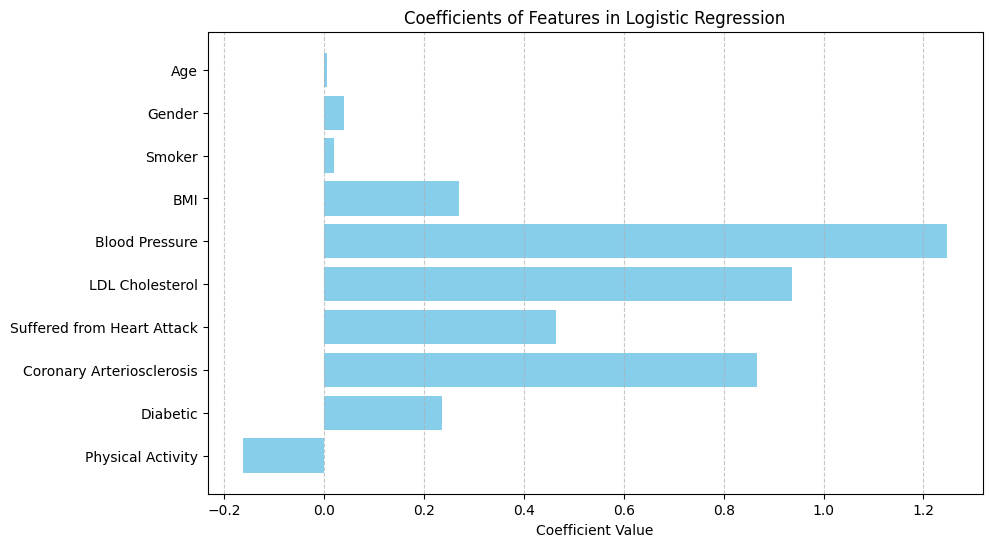



###################################################################




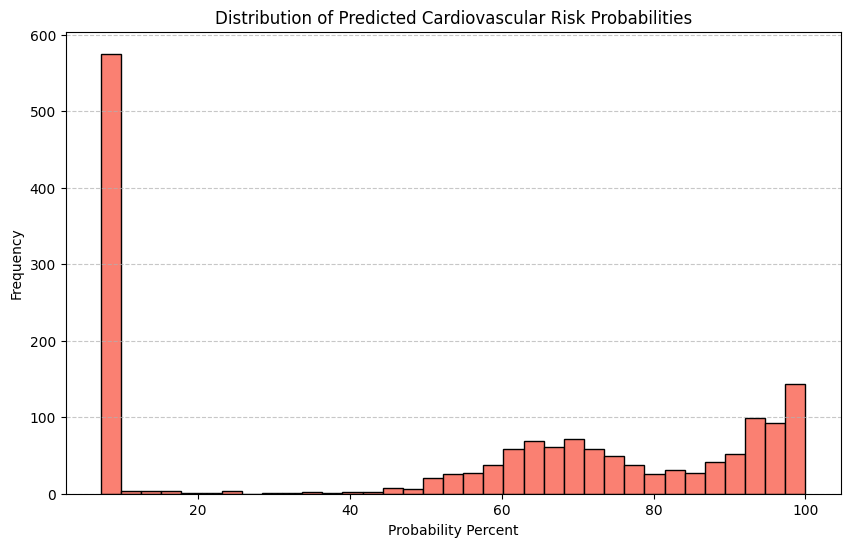



###################################################################




KeyError: 'Cardiovascular_Disease'

In [ ]:
from tabulate import tabulate
from IPython.display import display, HTML

print("\n")
print("###################################################################")
print("\n")

limited_df = results_df[['Patient_id', 'Predicted_Risk', 'Probability_Percent']].head(13)

styled_df = limited_df[['Patient_id', 'Predicted_Risk', 'Probability_Percent']].style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'),('color', 'black'), ('text-align', 'center')]}]
).set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# Mostra la tabella
display(styled_df)

# Eseguiamo la cross-validation
results = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

print("\n")
print("###################################################################")
print("\n")

# -------- Media delle performance --------

# Crea un DataFrame per media e varianza delle accuracy
accuracy_df = pd.DataFrame({
    'Metric': ['Mean Accuracy', 'Accuracy Variance'],
    'Value': [np.mean(results), np.std(results)]
})

# Stile della tabella
styled_accuracy_df = accuracy_df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('text-align', 'center')]}]
).set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# Mostra la tabella
display(styled_accuracy_df)

print("\n")
print("###################################################################")
print("\n")

features = ['Physical Activity', 'Diabetic', 'Coronary Arteriosclerosis', 'Suffered from Heart Attack', 'LDL Cholesterol', 'Blood Pressure', 'BMI', 'Smoker', 'Gender', 'Age']

# Estrai i coefficienti delle feature
coefficients = model.named_steps['model'].coef_[-1]  # Coefficienti

# Crea un DataFrame con i coefficienti
coefficients_pd = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})
#print(coefficients_pd)

# Stile per la tabella dei coefficienti
styled_coefficients_df = coefficients_pd.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'),('text-align', 'center')]}]
).set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# Mostra la tabella dei coefficienti
display(styled_coefficients_df)

print("\n")
print("###################################################################")
print("\n")

# Visualizzazione dei coefficienti
plt.figure(figsize=(10, 6))
plt.barh(coefficients_pd['Feature'], coefficients_pd['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Coefficients of Features in Logistic Regression')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("\n")
print("###################################################################")
print("\n")

# Visualizzazione delle probabilità predette
plt.figure(figsize=(10, 6))
plt.hist(results_df['Probability_Percent'], bins=35, color='salmon', edgecolor='black')
plt.xlabel('Probability Percent')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Cardiovascular Risk Probabilities')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n")
print("###################################################################")
print("\n")

fpr, tpr, thresholds = roc_curve(results_df['Cardiovascular_Disease'], results_df['Probability_Percent'])
auc_score = roc_auc_score(results_df['Cardiovascular_Disease'], results_df['Probability_Percent'])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n")
print("###################################################################")
print("\n")

precision, recall, _ = precision_recall_curve(results_df['Cardiovascular_Disease'], results_df['Probability_Percent'])

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

print("\n")
print("###################################################################")
print("\n")

## Correlation Study

,Correlation,Result
0,Pearson,-0.413919
1,Spearman,-0.370498




###################################################################




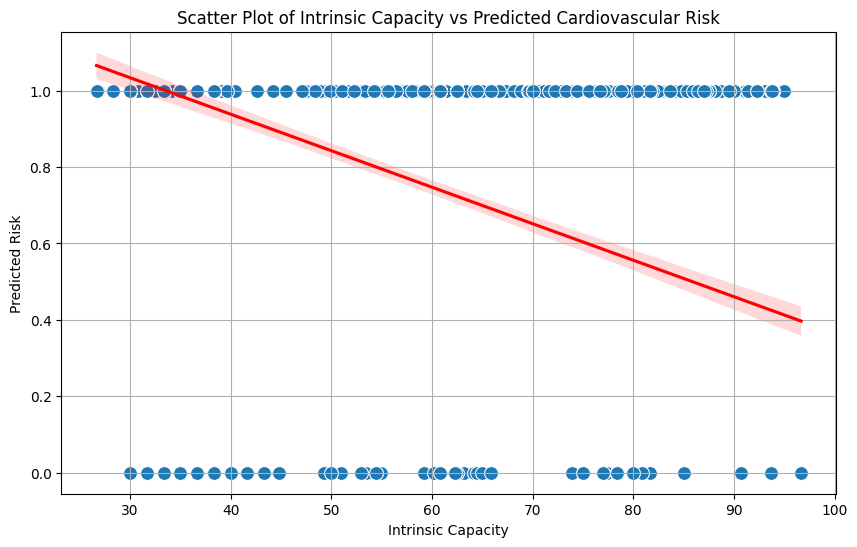

In [ ]:
import seaborn as sns

dfCorrelation = pd.merge(dfRisk_Final, dfIC_Final, on='Patient_id')

# Pearson Correlation
pearson_corr = dfCorrelation['Predicted_Risk'].corr(dfCorrelation
                        ['Intrinsic Capacity'], method='pearson')

# Spearman Correlation
spearman_corr = dfCorrelation['Predicted_Risk'].corr(dfCorrelation
                        ['Intrinsic Capacity'], method='spearman')

# Create a DataFrame containing Correlation's results
correlation_results = {
    'Correlation': ['Pearson', 'Spearman'],
    'Result': [pearson_corr, spearman_corr]
}



correlation_df = pd.DataFrame(correlation_results)

# Stile della tabella
styled_correlation_df = correlation_df.style.set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('text-align', 'center')]}]
).set_properties(**{'text-align': 'center', 'border': '1px solid black'})

# Mostra la tabella
display(styled_correlation_df)

print("\n")
print("###################################################################")
print("\n")

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Intrinsic Capacity', y='Predicted_Risk', data=dfCorrelation, s=100)
sns.regplot(x='Intrinsic Capacity', y='Predicted_Risk', data=dfCorrelation, scatter=False, color='red')

# Adding labels
plt.title('Scatter Plot of Intrinsic Capacity vs Predicted Cardiovascular Risk')
plt.xlabel('Intrinsic Capacity')
plt.ylabel('Predicted Risk')
plt.grid(True)

# Show the plot
plt.show()

# [ANALAYTICS](https://unimi2013-my.sharepoint.com/:x:/g/personal/mattia_occhipinti_unimi_it/EfH2kwGHllVNvysPWuqfUNIB3r6w6jtX-t84YpbyQN5e-A?rtime=r3GpQFDP3Eg)

## Analytics 1.5 - Age Distribution

In [ ]:
# Age distribution of recruited study participants

from pyspark.sql import functions as F

def calculate_age_group_statistics(df, age_col="Age"):
    # Defining groups
    bins = [29, 39, 49, 49, 59, 69, 79, 100]
    labels = ["0-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]

    # New column for groups
    df = df.withColumn("AgeGroup",
                       F.when((F.col(age_col) >= 0) & (F.col(age_col) <= 29), "0-29")
                       .when((F.col(age_col) >= 30) & (F.col(age_col) <= 39), "30-39")
                       .when((F.col(age_col) >= 40) & (F.col(age_col) <= 49), "40-49")
                       .when((F.col(age_col) >= 50) & (F.col(age_col) <= 59), "50-59")
                       .when((F.col(age_col) >= 60) & (F.col(age_col) <= 69), "60-69")
                       .when((F.col(age_col) >= 70) & (F.col(age_col) <= 79), "70-79")
                       .otherwise("80+")
                       )

    # Calculating participants, mean and dev for every group
    result = df.groupBy("AgeGroup") \
               .agg(
                   F.count("*").alias("N"),
                   F.mean(age_col).alias("Mean"),
                   F.stddev(age_col).alias("StdDev")
               ) \
               .orderBy("AgeGroup")

    return result

# Calling the function
age_statistics = calculate_age_group_statistics(dfAge)

# Showing results
#age_statistics.show(truncate=False)
#print(f"Number of active patients: {num_active_patients}")

# Creating E-Chart

def create_age_distribution_chart(df: DataFrame):
    # Converting PySpark DataFrame into DataFrame Pandas
    df_pd = df.toPandas()

    # Data Extraction
    age_groups = df_pd['AgeGroup'].tolist()
    n_participants = df_pd['N'].tolist()
    means = df_pd['Mean'].tolist()
    std_devs = df_pd['StdDev'].fillna(0).tolist()  # Fills null with 0 for empty std dev

    # Formatting Labels
    labels = [f"Mean: {means[i]:.2f}\nStd Dev: {std_devs[i]:.2f}\nN: {n_participants[i]}" for i in range(len(age_groups))]

    # Graph Creation
    bar = (
        Bar()
        .add_xaxis(age_groups)
        .add_yaxis(
            "# of Participants",
            n_participants,
            label_opts=opts.LabelOpts(
                is_show=True,
                position="top",
                formatter=JsCode(
                    """
                    function(x) {
                        const labels = %s;
                        return labels[x.dataIndex];
                    }
                    """ % labels
                )
            ),
            category_gap="30%"
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(title="Profiling of Patients"),
            xaxis_opts=opts.AxisOpts(name="Age Groups", name_textstyle_opts=opts.TextStyleOpts(font_weight='bold'), axislabel_opts=opts.LabelOpts(font_weight='bold')),
            yaxis_opts=opts.AxisOpts(name="# of Participants", max_=1200, axislabel_opts=opts.LabelOpts(font_weight='bold')),
            tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="shadow", formatter=lambda params: f"<b>{params.name}</b><br>{labels[params.dataIndex]}")
        )
    )

    # Graph Render
    return bar

# Calling the functions
bar_chart = create_age_distribution_chart(age_statistics)

# Saving results
bar_chart.render("age_distribution.html")
from google.colab import files
files.download("age_distribution.html")

# Showing results
#bar_chart.render_notebook()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analytics 2.5 - Comorbidities profiles per age group

In [ ]:
dfFinal = dfVitalityConditions.join(dfAge, on='Patient_id', how='inner')
dfFinal = dfFinal.select('Patient_id', 'Age', *dfVitalityConditions.columns[1:])

# Calling Age Distribution and Chart functions
dfFinal = create_age_groups(dfFinal)
dfSummary = sum_patients_per_condition(dfFinal)
age_groups, data = prepare_data_for_echarts(dfSummary)
bar_chart = create_stacked_bar_chart(age_groups, data)

# Saving results
bar_chart.render("age_distribution_conditions.html")
from google.colab import files
files.download("age_distribution_conditions.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TEST 1

### Run 1

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression

# Selezionare le feature e il target
feature_columns = ['Physical Activity', 'Diabetic', 'Cardiac Patient', 'Suffered from Heart Attack', 'LDL Cholesterol', 'Blood Pressure', 'BMI', 'Smoker', 'Gender', 'Age']
target_column = 'Cardiovascular_Disease'

# ---------------

# Calcolo la frequenza della classe
class_frequency = dfFinal.groupBy(target_column).count().collect()

# Calcolo il peso della classe
total_sample = dfFinal_Count
class_weights = {row[target_column]: total_sample / row['count'] for row in class_frequency}

# Creo una colonna di pesi nel DataFrame
dfFinal = dfFinal.withColumn('weights', F.when(dfFinal['Cardiovascular_Disease'] == 0, class_weights[0]).otherwise(class_weights[1]))

# ---------------

# Step 1: Assembla le feature in un unico vettore
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_assembled")

# Step 2: Normalizzazione (Z-score scaling)
scaler = StandardScaler(inputCol="features_assembled", outputCol="features_scaled", withMean=True, withStd=True)

# Step 3: Modello di regressione logistica
lr = LogisticRegression(featuresCol="features_scaled", labelCol=target_column, predictionCol="Cardio_Risk", probabilityCol="probability", weightCol='weights')

# Step 4: Pipeline di trasformazione e modello
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Dividi i dati in training e test (80% training, 20% test)
train_df, test_df = dfFinal.randomSplit([0.8, 0.2], seed=42)

# Step 5: Allena il modello
model = pipeline.fit(train_df)

# Step 6: Prevedi il rischio cardiovascolare
predictions = model.transform(test_df)

### Show Results 1

                      Feature  Coefficient
0           Physical Activity    -0.169401
1                    Diabetic     0.185048
2             Cardiac Patient     3.491667
3  Suffered from Heart Attack     0.431495
4             LDL Cholesterol     0.909458
5              Blood Pressure     1.161585
6                         BMI     0.352003
7                      Smoker     0.049066
8                      Gender     0.021388
9                         Age     0.074667


###################################################################




###################################################################




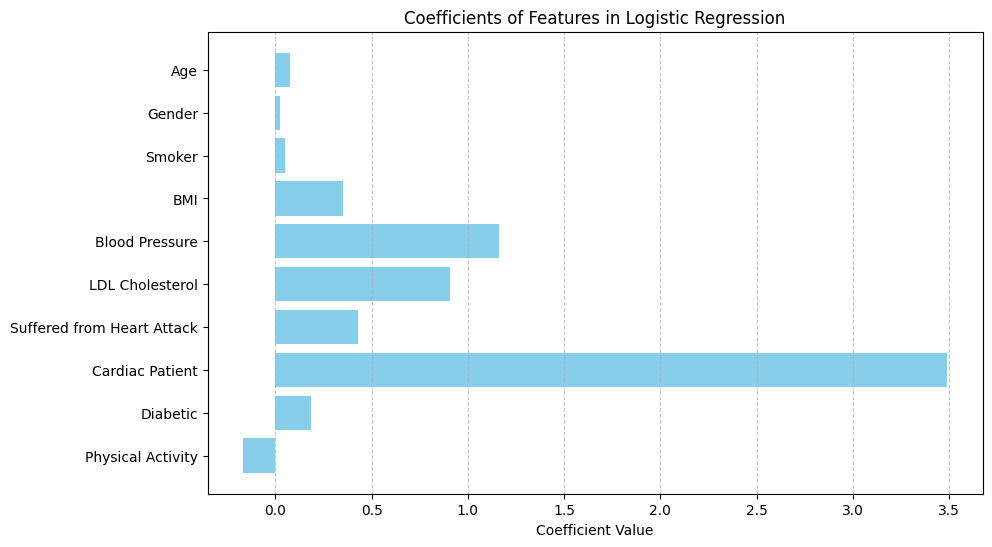



###################################################################




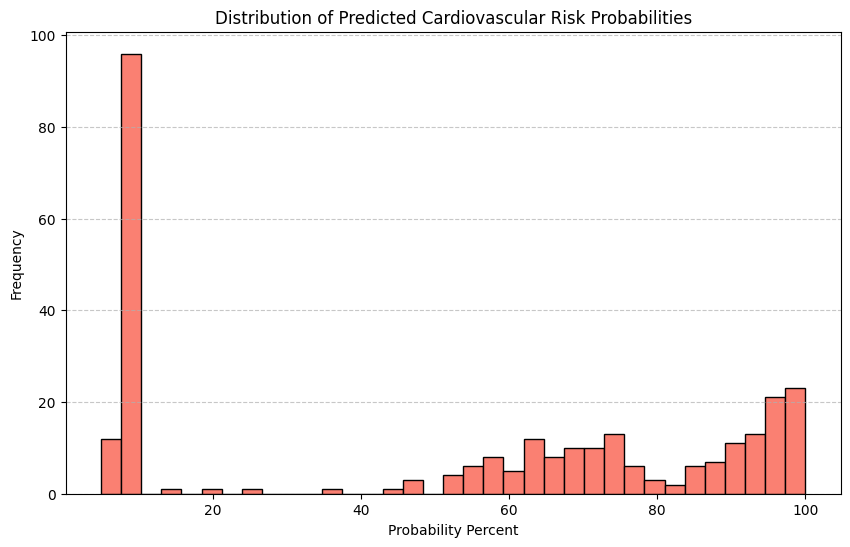



###################################################################




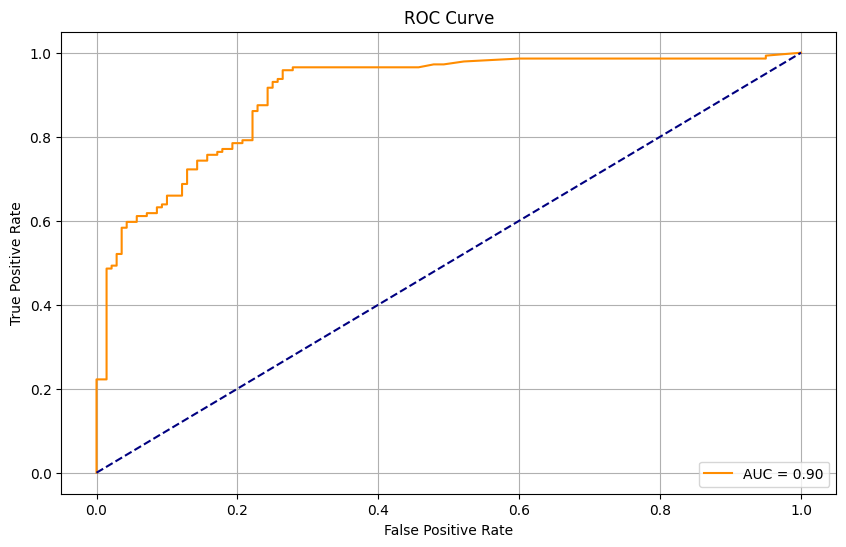



###################################################################




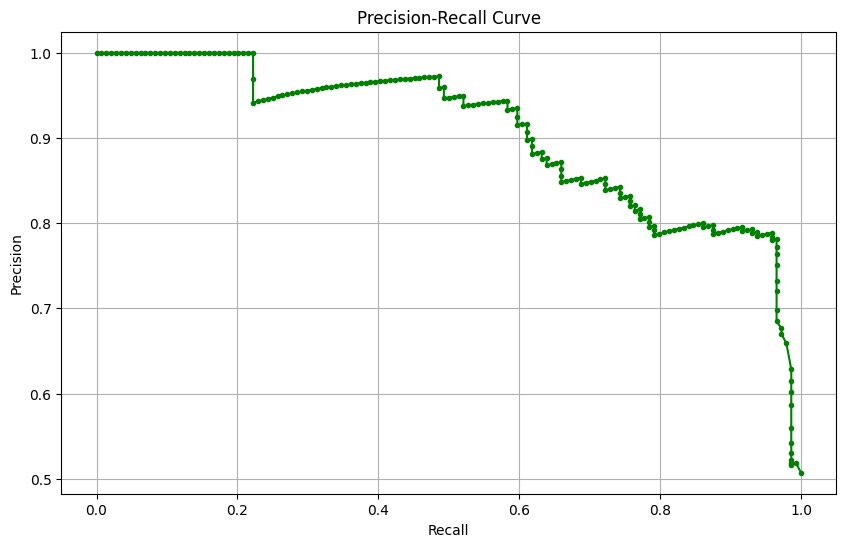



###################################################################




In [ ]:

# Step 7: Estrai i coefficienti delle feature
coefficients = model.stages[-1].coefficients.toArray()
intercept = model.stages[-1].intercept

# Converte i coefficienti in formato Pandas DataFrame
coefficients_pd = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': coefficients
})
print(coefficients_pd)

# Salvo i coefficienti
#coefficients_pd.to_parquet('coefficients.parquet', index=False)
#from google.colab import files
#files.download('coefficients.parquet')

print("\n")
print("###################################################################")
print("\n")

# Definisci una funzione UDF per estrarre la probabilità per la classe positiva (1)
def extract_probability(probability_vector):
    # Assumendo che la classe positiva sia sempre l'indice 1
    return float(probability_vector[1])

# Registra la funzione UDF
extract_probability_udf = udf(extract_probability, DoubleType())

# Applica l'UDF per ottenere la probabilità percentuale
result_df = predictions.withColumn("probability_percent", extract_probability_udf(F.col("probability")) * 100)

#HDL_Corr = result_df.select('HDL Cholesterol', 'Cardio_Risk').corr('HDL Cholesterol', 'Cardio_Risk')
#print('Correlazione tra HDL e rischio: ', HDL_Corr)

print("\n")
print("###################################################################")
print("\n")

# Seleziona le colonne finali per il risultato
result_df = result_df.select("Patient_id", "Cardio_Risk", "probability_percent", "Cardiovascular_Disease")

# Converti il DataFrame PySpark in Pandas per la visualizzazione
final_results_pd = result_df.toPandas()

# Scarico il DataFrame in parquet
#final_results_pd.to_parquet('final_results.parquet', index=False)
#from google.colab import files
#files.download('final_results.parquet')

# Visualizzazione dei coefficienti
plt.figure(figsize=(10, 6))
plt.barh(coefficients_pd['Feature'], coefficients_pd['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Coefficients of Features in Logistic Regression')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("\n")
print("###################################################################")
print("\n")

# Visualizzazione delle probabilità predette
plt.figure(figsize=(10, 6))
plt.hist(final_results_pd['probability_percent'], bins=35, color='salmon', edgecolor='black')
plt.xlabel('Probability Percent')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Cardiovascular Risk Probabilities')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n")
print("###################################################################")
print("\n")

fpr, tpr, thresholds = roc_curve(final_results_pd['Cardiovascular_Disease'], final_results_pd['probability_percent'])
auc_score = roc_auc_score(final_results_pd['Cardiovascular_Disease'], final_results_pd['probability_percent'])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n")
print("###################################################################")
print("\n")

precision, recall, _ = precision_recall_curve(final_results_pd['Cardiovascular_Disease'], final_results_pd['probability_percent'])

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

print("\n")
print("###################################################################")
print("\n")